In [ ]:
!pip install torchmetrics

# PyTorch Debugging Interview

This notebook implements a simple image classifier to classify images from the CIFAR dataset.  The task is to classify the images into 10 categories (frog, airplane, etc.) based on which object is depicted in the image.

The cells below contain an implementation of a training loop for this classifier - but it has some problems and doesn't work! We need your help to fix it. Feel free to look up any documentation you might need along the way, just let your interviewer know what information you're seeking.

The problem is considered "solved" if you get > 71% accuracy on the validation set, but it is possible to achieve 74% accuracy without over-complicated tricks. Good luck!

Tips:
*   First, focus on getting the notebook to run smoothly (compile) all the way through, then focus on improving model performance.
*   It should be possible to arrive at a working solution without any time-intensive steps like exhaustive hyper-parameter tuning, we recommend first testing improvements that you can validate quickly before spending a lot of time on any one improvement.



# A bit about the CIFAR dataset
The CIFAR dataset is a simple image dataset consisting of images depicting 10 classes of objects. These images are RGB (3 channel) with resolution (32 x 32)

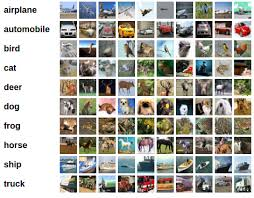

In [ ]:
import os
import PIL

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchmetrics
import torchvision
from torch import Tensor, nn
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import datasets, transforms
from tqdm import tqdm

### Section 1: Data Loading

In [ ]:
example = datasets.CIFAR10(root=os.getcwd(), train=True, download=True)[0]
image, label = example
print("label:", label)
image.resize((256, 256))

In [ ]:
def custom_transform(img):
   img = transforms.functional.pil_to_tensor(img),
   transforms.RandomHorizontalFlip()
   return img

train_dataset = datasets.CIFAR10(root=os.getcwd(), transform=custom_transform, train=True, download=True)
val_dataset = datasets.CIFAR10(root=os.getcwd(), transform=custom_transform, train=False, download=True)

### Section 2: Define Model Architecture

In [67]:
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels: int, n_features: int, p_dropout: float):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, n_features, kernel_size=3),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=p_dropout, inplace=False),
        )

    def forward(self, x: Tensor):
      # print("run ds: ", x.shape)  # run ds:  torch.Size([1, 128, 6, 6]) ->x.shape: torch.Size([1, 256, 2, 2])
      return self.layers(x)


class ClassificationHead(nn.Sequential):
    def __init__(self, input_features: int, n_classes: int = 10):
        """3 layer MLP"""
        super().__init__(
            nn.Linear(input_features, input_features//2), # 1024, 512
            nn.ReLU(True),
            nn.Linear(input_features//2, input_features//4),
            nn.ReLU(True),
            nn.Linear(input_features//4, input_features//8),
            nn.ReLU(True),
            nn.Linear(input_features//8, n_classes),
            nn.Softmax(dim=-1),
        )

class Net(nn.Module):
    def __init__(self, in_channels: int = 3, n_blocks: int = 3, final_feature_dim: int = 256, p_dropout: float = 0.1):
        super().__init__()
        layers = []
        curr_channels = in_channels
        n_features = int(final_feature_dim / (2 ** (n_blocks - 1)))
        for i in range(n_blocks):
          layers.append(DownsampleBlock(curr_channels, n_features, p_dropout))
          curr_channels = n_features
          n_features *= 2 # double feature size

        # print("curr_channels: ", curr_channels) # 256
        # Add output head - 3 layer MLP
        layers.append(ClassificationHead(curr_channels * 2 * 2, n_classes=10))
        self.layers = nn.Sequential(*layers)

    def forward(self, x: Tensor):
        for i in range(len(self.layers)-1):
            x = self.layers[i](x)
            # print("x.shape:", x.shape)

        # classification
        x = x.view(x.size(0), -1)
        # print("x size before classifier: ", x.shape)
        x = self.layers[-1](x)
        # for layer in self.layers:
        #     x = layer(x)
        #     print("x.shape:", x.shape)  # x.shape: torch.Size([1, 256, 2, 2])
        return x

In [68]:
model = Net().cuda()
print(model)

Net(
  (layers): Sequential(
    (0): DownsampleBlock(
      (layers): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (1): DownsampleBlock(
      (layers): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (2): DownsampleBlock(
      (layers): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (3): ClassificationHead(
      (0): Linear(in_features=1024, out_features=512, bias

In [ ]:
# Check that we can make a forward pass with an instance of the model
test_image = train_dataset[0][0]
# print("test_image: ", test_image, test_image.shape)
test_image = test_image.to(torch.float)
test_image = test_image.unsqueeze(0).cuda() # shape (1, 3, 32, 32)
preds = model(test_image)
# preds, preds.sum()

In [ ]:
summary(model, (3, 32, 32), device="cuda") # Image Resolution (32, 32), with 3 channels (RGB)

### Section 3: Define the Training Loop!

In [ ]:
from torchmetrics import Metric

class AverageLoss(Metric):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.add_state("losses", default=torch.tensor(0, dtype=torch.float32), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, loss: Tensor) -> None:
        self.losses += loss.item()
        self.total += 1

    def compute(self) -> Tensor:
        return self.losses / self.total

In [70]:
def train_one_epoch(model, dataloader, optimizer, print_interval=50, device="cuda"):
    """Defines one pass over the train dataloader, prints average metrics over print_interval steps."""
    accuracy_metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
    loss_metric = AverageLoss()
    for i, batch in enumerate(tqdm(dataloader)):
        x, y = batch
        # y = y.to(torch.float)
        x = x.to(torch.float)
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        # Cross-Entropy expects logits as input
        loss = F.cross_entropy(output, y)
        loss_metric(loss)
        accuracy_metric(output.cpu(), y.cpu())
        if i % print_interval == 0:
          print(f"Iteration: {i}, mean loss: {loss_metric.compute()}, train_accuracy:{accuracy_metric.compute()}")
          accuracy_metric.reset, loss_metric.reset()
        loss.backward()
        optimizer.step()

def evaluate(model, val_dataloader, device="cuda"):
    """Defines a validation loop, computes validation metrics over the entire val dataloader."""
    accuracy_metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
    loss_metric = AverageLoss()
    model.eval()
    for i, batch in enumerate(tqdm(val_dataloader)):
      x, y = batch
      x = x.to(device)
      x = x.to(torch.float)
      y = y.to(device)
      with torch.no_grad():
        output = model(x)
      loss = F.cross_entropy(output, y)
      loss_metric(loss)
      accuracy_metric(output.cpu(), y.cpu())
      current_loss, current_accuracy = loss_metric.compute(), accuracy_metric.compute()
    print("Val Metrics: val loss:", current_loss, "val accuracy:", current_accuracy)
    model.train()
    return current_accuracy

In [87]:
# Hyperparameters
N_EPOCHS = 100
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
DEVICE="cuda"

In [88]:
model = Net().to(DEVICE)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    pin_memory_device=DEVICE
)
val_dataloader = DataLoader(
    val_dataset,  # test_image = test_image.to(torch.float)
    batch_size=BATCH_SIZE,
    pin_memory=True,
    pin_memory_device=DEVICE
)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
for _ in range(N_EPOCHS):
  train_one_epoch(model, train_dataloader, optimizer)
  val_accuracy = evaluate(model, val_dataloader)

print("FINAL VALIDATION ACCURACY:", val_accuracy)

  3%|▎         | 13/391 [00:00<00:06, 61.47it/s]

Iteration: 0, mean loss: 2.29905366897583, train_accuracy:0.1015625


 15%|█▍        | 58/391 [00:00<00:04, 69.67it/s]

Iteration: 50, mean loss: 2.3000130653381348, train_accuracy:0.10033700615167618


 28%|██▊       | 110/391 [00:01<00:04, 69.31it/s]

Iteration: 100, mean loss: 2.289975643157959, train_accuracy:0.11215965449810028


 41%|████      | 160/391 [00:02<00:03, 66.67it/s]

Iteration: 150, mean loss: 2.27557110786438, train_accuracy:0.12934602797031403


 54%|█████▎    | 210/391 [00:03<00:02, 65.28it/s]

Iteration: 200, mean loss: 2.256390333175659, train_accuracy:0.14408425986766815


 67%|██████▋   | 262/391 [00:03<00:01, 67.67it/s]

Iteration: 250, mean loss: 2.2432711124420166, train_accuracy:0.15677914023399353


 79%|███████▉  | 309/391 [00:04<00:01, 53.15it/s]

Iteration: 300, mean loss: 2.2327001094818115, train_accuracy:0.16720306873321533


 91%|█████████ | 356/391 [00:05<00:00, 49.01it/s]

Iteration: 350, mean loss: 2.226414442062378, train_accuracy:0.17516915500164032


100%|██████████| 79/79 [00:00<00:00, 80.70it/s]


Val Metrics: val loss: tensor(2.2064) val accuracy: tensor(0.2459)


  2%|▏         | 8/391 [00:00<00:05, 70.66it/s]

Iteration: 0, mean loss: 2.232604503631592, train_accuracy:0.203125


 16%|█▌        | 61/391 [00:00<00:04, 68.72it/s]

Iteration: 50, mean loss: 2.2002108097076416, train_accuracy:0.250612735748291


 29%|██▉       | 113/391 [00:01<00:03, 69.76it/s]

Iteration: 100, mean loss: 2.2142605781555176, train_accuracy:0.24350246787071228


 42%|████▏     | 165/391 [00:02<00:03, 69.31it/s]

Iteration: 150, mean loss: 2.2039988040924072, train_accuracy:0.24601614475250244


 53%|█████▎    | 209/391 [00:03<00:02, 69.73it/s]

Iteration: 200, mean loss: 2.179910182952881, train_accuracy:0.2529151141643524


 66%|██████▋   | 260/391 [00:03<00:01, 69.01it/s]

Iteration: 250, mean loss: 2.186007261276245, train_accuracy:0.2552913427352905


 80%|███████▉  | 312/391 [00:04<00:01, 69.29it/s]

Iteration: 300, mean loss: 2.1807501316070557, train_accuracy:0.25851330161094666


 93%|█████████▎| 362/391 [00:05<00:00, 67.24it/s]

Iteration: 350, mean loss: 2.168613910675049, train_accuracy:0.26248663663864136


100%|██████████| 79/79 [00:00<00:00, 79.90it/s]


Val Metrics: val loss: tensor(2.1529) val accuracy: tensor(0.3103)


  2%|▏         | 7/391 [00:00<00:05, 68.23it/s]

Iteration: 0, mean loss: 2.1620383262634277, train_accuracy:0.3125


 15%|█▌        | 59/391 [00:00<00:04, 69.02it/s]

Iteration: 50, mean loss: 2.1549036502838135, train_accuracy:0.30422794818878174


 28%|██▊       | 110/391 [00:01<00:04, 67.67it/s]

Iteration: 100, mean loss: 2.1628310680389404, train_accuracy:0.29950493574142456


 39%|███▉      | 153/391 [00:02<00:03, 64.58it/s]

Iteration: 150, mean loss: 2.1543843746185303, train_accuracy:0.29920321702957153


 53%|█████▎    | 208/391 [00:03<00:03, 52.39it/s]

Iteration: 200, mean loss: 2.1336662769317627, train_accuracy:0.30635884404182434


 66%|██████▋   | 260/391 [00:04<00:02, 53.15it/s]

Iteration: 250, mean loss: 2.136598587036133, train_accuracy:0.3089517056941986


 79%|███████▉  | 310/391 [00:05<00:01, 61.74it/s]

Iteration: 300, mean loss: 2.1375486850738525, train_accuracy:0.310890793800354


 92%|█████████▏| 359/391 [00:05<00:00, 66.35it/s]

Iteration: 350, mean loss: 2.129990339279175, train_accuracy:0.31303417682647705


100%|██████████| 79/79 [00:00<00:00, 80.28it/s]


Val Metrics: val loss: tensor(2.1212) val accuracy: tensor(0.3391)


  2%|▏         | 7/391 [00:00<00:05, 69.49it/s]

Iteration: 0, mean loss: 2.142346143722534, train_accuracy:0.3125


 16%|█▌        | 63/391 [00:00<00:04, 67.90it/s]

Iteration: 50, mean loss: 2.1200640201568604, train_accuracy:0.33700981736183167


 29%|██▉       | 114/391 [00:01<00:04, 67.72it/s]

Iteration: 100, mean loss: 2.1266679763793945, train_accuracy:0.3323793411254883


 41%|████      | 159/391 [00:02<00:03, 68.80it/s]

Iteration: 150, mean loss: 2.1197192668914795, train_accuracy:0.3344888389110565


 54%|█████▎    | 210/391 [00:03<00:02, 69.27it/s]

Iteration: 200, mean loss: 2.1060338020324707, train_accuracy:0.33850279450416565


 67%|██████▋   | 262/391 [00:03<00:01, 68.07it/s]

Iteration: 250, mean loss: 2.1044766902923584, train_accuracy:0.3422248363494873


 80%|████████  | 313/391 [00:04<00:01, 66.28it/s]

Iteration: 300, mean loss: 2.1037850379943848, train_accuracy:0.34419122338294983


 93%|█████████▎| 364/391 [00:05<00:00, 67.35it/s]

Iteration: 350, mean loss: 2.0994462966918945, train_accuracy:0.34686610102653503


100%|██████████| 79/79 [00:00<00:00, 80.37it/s]


Val Metrics: val loss: tensor(2.0962) val accuracy: tensor(0.3644)


  2%|▏         | 7/391 [00:00<00:05, 67.85it/s]

Iteration: 0, mean loss: 2.082278251647949, train_accuracy:0.3828125


 14%|█▍        | 55/391 [00:01<00:07, 42.54it/s]

Iteration: 50, mean loss: 2.0896074771881104, train_accuracy:0.36534926295280457


 28%|██▊       | 109/391 [00:02<00:05, 50.56it/s]

Iteration: 100, mean loss: 2.0929436683654785, train_accuracy:0.36556312441825867


 41%|████      | 159/391 [00:03<00:03, 66.05it/s]

Iteration: 150, mean loss: 2.0872576236724854, train_accuracy:0.3652731776237488


 54%|█████▎    | 210/391 [00:03<00:02, 68.88it/s]

Iteration: 200, mean loss: 2.078188419342041, train_accuracy:0.3686645030975342


 66%|██████▋   | 260/391 [00:04<00:01, 67.68it/s]

Iteration: 250, mean loss: 2.077322244644165, train_accuracy:0.37142056226730347


 79%|███████▉  | 310/391 [00:05<00:01, 65.47it/s]

Iteration: 300, mean loss: 2.0788075923919678, train_accuracy:0.37362438440322876


 92%|█████████▏| 360/391 [00:06<00:00, 66.03it/s]

Iteration: 350, mean loss: 2.0694963932037354, train_accuracy:0.37615740299224854


100%|██████████| 79/79 [00:00<00:00, 80.58it/s]


Val Metrics: val loss: tensor(2.0578) val accuracy: tensor(0.4040)


  2%|▏         | 7/391 [00:00<00:05, 68.98it/s]

Iteration: 0, mean loss: 2.0302226543426514, train_accuracy:0.4140625


 16%|█▋        | 64/391 [00:00<00:04, 68.78it/s]

Iteration: 50, mean loss: 2.066239833831787, train_accuracy:0.391237735748291


 29%|██▉       | 113/391 [00:01<00:04, 66.81it/s]

Iteration: 100, mean loss: 2.0768985748291016, train_accuracy:0.3838180601596832


 42%|████▏     | 164/391 [00:02<00:03, 68.90it/s]

Iteration: 150, mean loss: 2.0658648014068604, train_accuracy:0.38581332564353943


 55%|█████▍    | 215/391 [00:03<00:02, 69.15it/s]

Iteration: 200, mean loss: 2.058690309524536, train_accuracy:0.38910913467407227


 68%|██████▊   | 264/391 [00:03<00:01, 66.23it/s]

Iteration: 250, mean loss: 2.055792808532715, train_accuracy:0.39162102341651917


 80%|████████  | 313/391 [00:04<00:01, 66.66it/s]

Iteration: 300, mean loss: 2.0583877563476562, train_accuracy:0.3928830921649933


 91%|█████████▏| 357/391 [00:05<00:00, 51.17it/s]

Iteration: 350, mean loss: 2.049642562866211, train_accuracy:0.3949652910232544


100%|██████████| 79/79 [00:01<00:00, 63.79it/s]


Val Metrics: val loss: tensor(2.0488) val accuracy: tensor(0.4095)


  2%|▏         | 7/391 [00:00<00:05, 68.32it/s]

Iteration: 0, mean loss: 1.9925987720489502, train_accuracy:0.46875


 15%|█▍        | 58/391 [00:00<00:04, 66.69it/s]

Iteration: 50, mean loss: 2.041086435317993, train_accuracy:0.4195772111415863


 28%|██▊       | 109/391 [00:01<00:04, 67.77it/s]

Iteration: 100, mean loss: 2.0530359745025635, train_accuracy:0.41143256425857544


 40%|████      | 158/391 [00:02<00:03, 67.47it/s]

Iteration: 150, mean loss: 2.048722982406616, train_accuracy:0.41064777970314026


 53%|█████▎    | 208/391 [00:03<00:02, 67.42it/s]

Iteration: 200, mean loss: 2.03486967086792, train_accuracy:0.41386815905570984


 66%|██████▌   | 259/391 [00:03<00:01, 68.64it/s]

Iteration: 250, mean loss: 2.0445449352264404, train_accuracy:0.41331547498703003


 80%|███████▉  | 311/391 [00:04<00:01, 68.65it/s]

Iteration: 300, mean loss: 2.0502309799194336, train_accuracy:0.4119860827922821


 93%|█████████▎| 363/391 [00:05<00:00, 69.08it/s]

Iteration: 350, mean loss: 2.029956102371216, train_accuracy:0.4145299196243286


100%|██████████| 79/79 [00:00<00:00, 80.58it/s]


Val Metrics: val loss: tensor(2.0276) val accuracy: tensor(0.4379)


  2%|▏         | 7/391 [00:00<00:05, 68.73it/s]

Iteration: 0, mean loss: 1.975805401802063, train_accuracy:0.5


 15%|█▍        | 58/391 [00:00<00:04, 67.43it/s]

Iteration: 50, mean loss: 2.0307178497314453, train_accuracy:0.43045341968536377


 29%|██▉       | 115/391 [00:01<00:03, 69.32it/s]

Iteration: 100, mean loss: 2.0323119163513184, train_accuracy:0.42744430899620056


 42%|████▏     | 165/391 [00:02<00:03, 68.93it/s]

Iteration: 150, mean loss: 2.030128240585327, train_accuracy:0.42798012495040894


 54%|█████▍    | 211/391 [00:03<00:03, 51.59it/s]

Iteration: 200, mean loss: 2.024393320083618, train_accuracy:0.4301927983760834


 66%|██████▌   | 257/391 [00:04<00:02, 47.93it/s]

Iteration: 250, mean loss: 2.0269346237182617, train_accuracy:0.43068352341651917


 80%|███████▉  | 312/391 [00:05<00:01, 63.71it/s]

Iteration: 300, mean loss: 2.035391330718994, train_accuracy:0.4290905296802521


 92%|█████████▏| 358/391 [00:05<00:00, 69.18it/s]

Iteration: 350, mean loss: 2.0174896717071533, train_accuracy:0.4307781457901001


100%|██████████| 79/79 [00:00<00:00, 79.39it/s]


Val Metrics: val loss: tensor(2.0143) val accuracy: tensor(0.4478)


  2%|▏         | 7/391 [00:00<00:05, 68.18it/s]

Iteration: 0, mean loss: 1.9378688335418701, train_accuracy:0.5390625


 16%|█▋        | 64/391 [00:00<00:04, 67.47it/s]

Iteration: 50, mean loss: 2.0122716426849365, train_accuracy:0.44776347279548645


 28%|██▊       | 108/391 [00:01<00:04, 69.29it/s]

Iteration: 100, mean loss: 2.0185599327087402, train_accuracy:0.4439975321292877


 40%|████      | 158/391 [00:02<00:03, 68.90it/s]

Iteration: 150, mean loss: 2.014061450958252, train_accuracy:0.4452090263366699


 53%|█████▎    | 209/391 [00:03<00:02, 67.96it/s]

Iteration: 200, mean loss: 2.009427547454834, train_accuracy:0.446595162153244


 67%|██████▋   | 261/391 [00:03<00:01, 68.36it/s]

Iteration: 250, mean loss: 2.0106747150421143, train_accuracy:0.4470866620540619


 80%|███████▉  | 311/391 [00:04<00:01, 69.02it/s]

Iteration: 300, mean loss: 2.015723943710327, train_accuracy:0.4464026093482971


 92%|█████████▏| 361/391 [00:05<00:00, 68.58it/s]

Iteration: 350, mean loss: 2.0103871822357178, train_accuracy:0.44713765382766724


100%|██████████| 79/79 [00:01<00:00, 77.94it/s]


Val Metrics: val loss: tensor(1.9973) val accuracy: tensor(0.4676)


  2%|▏         | 7/391 [00:00<00:05, 67.69it/s]

Iteration: 0, mean loss: 1.9573264122009277, train_accuracy:0.5234375


 14%|█▍        | 56/391 [00:00<00:06, 54.45it/s]

Iteration: 50, mean loss: 1.995784878730774, train_accuracy:0.46537989377975464


 28%|██▊       | 110/391 [00:01<00:05, 52.26it/s]

Iteration: 100, mean loss: 2.002943992614746, train_accuracy:0.4609375


 42%|████▏     | 164/391 [00:03<00:03, 60.80it/s]

Iteration: 150, mean loss: 1.9941688776016235, train_accuracy:0.4637831151485443


 53%|█████▎    | 208/391 [00:03<00:02, 67.54it/s]

Iteration: 200, mean loss: 1.9925601482391357, train_accuracy:0.46470770239830017


 66%|██████▌   | 258/391 [00:04<00:02, 65.86it/s]

Iteration: 250, mean loss: 1.9944548606872559, train_accuracy:0.4656374454498291


 79%|███████▉  | 310/391 [00:05<00:01, 69.28it/s]

Iteration: 300, mean loss: 1.999314546585083, train_accuracy:0.464778870344162


 92%|█████████▏| 360/391 [00:05<00:00, 68.97it/s]

Iteration: 350, mean loss: 2.000511884689331, train_accuracy:0.4637419879436493


100%|██████████| 79/79 [00:00<00:00, 80.39it/s]


Val Metrics: val loss: tensor(2.0013) val accuracy: tensor(0.4607)


  2%|▏         | 7/391 [00:00<00:06, 62.68it/s]

Iteration: 0, mean loss: 1.9236457347869873, train_accuracy:0.5859375


 15%|█▍        | 58/391 [00:00<00:04, 68.76it/s]

Iteration: 50, mean loss: 1.9862284660339355, train_accuracy:0.4765625


 28%|██▊       | 111/391 [00:01<00:04, 69.32it/s]

Iteration: 100, mean loss: 1.9897637367248535, train_accuracy:0.4730043411254883


 41%|████▏     | 162/391 [00:02<00:03, 67.08it/s]

Iteration: 150, mean loss: 1.9889417886734009, train_accuracy:0.47221648693084717


 54%|█████▍    | 213/391 [00:03<00:02, 69.14it/s]

Iteration: 200, mean loss: 1.9793516397476196, train_accuracy:0.47353076934814453


 67%|██████▋   | 263/391 [00:03<00:01, 67.88it/s]

Iteration: 250, mean loss: 1.978183388710022, train_accuracy:0.47556647658348083


 81%|████████  | 315/391 [00:04<00:01, 68.67it/s]

Iteration: 300, mean loss: 1.9858999252319336, train_accuracy:0.4753166437149048


 92%|█████████▏| 358/391 [00:05<00:00, 67.25it/s]

Iteration: 350, mean loss: 1.985655665397644, train_accuracy:0.4750712215900421


100%|██████████| 79/79 [00:01<00:00, 54.67it/s]


Val Metrics: val loss: tensor(1.9717) val accuracy: tensor(0.4948)


  1%|          | 4/391 [00:00<00:09, 39.09it/s]

Iteration: 0, mean loss: 1.902782678604126, train_accuracy:0.5390625


 16%|█▌        | 62/391 [00:00<00:04, 67.92it/s]

Iteration: 50, mean loss: 1.968845009803772, train_accuracy:0.4924938678741455


 28%|██▊       | 111/391 [00:01<00:04, 68.21it/s]

Iteration: 100, mean loss: 1.9793957471847534, train_accuracy:0.4877011179924011


 41%|████      | 161/391 [00:02<00:03, 67.81it/s]

Iteration: 150, mean loss: 1.9730279445648193, train_accuracy:0.4893418848514557


 54%|█████▍    | 211/391 [00:03<00:02, 66.66it/s]

Iteration: 200, mean loss: 1.9703161716461182, train_accuracy:0.489116907119751


 67%|██████▋   | 262/391 [00:03<00:01, 68.58it/s]

Iteration: 250, mean loss: 1.9705381393432617, train_accuracy:0.4891994595527649


 80%|███████▉  | 312/391 [00:04<00:01, 67.63it/s]

Iteration: 300, mean loss: 1.976508617401123, train_accuracy:0.4885278344154358


 93%|█████████▎| 363/391 [00:05<00:00, 67.89it/s]

Iteration: 350, mean loss: 1.973650336265564, train_accuracy:0.4880252778530121


100%|██████████| 79/79 [00:01<00:00, 78.93it/s]


Val Metrics: val loss: tensor(1.9644) val accuracy: tensor(0.4972)


  2%|▏         | 7/391 [00:00<00:05, 69.83it/s]

Iteration: 0, mean loss: 1.8761708736419678, train_accuracy:0.5859375


 15%|█▍        | 57/391 [00:00<00:04, 67.91it/s]

Iteration: 50, mean loss: 1.956620216369629, train_accuracy:0.5070465803146362


 27%|██▋       | 107/391 [00:01<00:04, 66.61it/s]

Iteration: 100, mean loss: 1.9680382013320923, train_accuracy:0.5


 40%|████      | 158/391 [00:02<00:03, 69.16it/s]

Iteration: 150, mean loss: 1.9631052017211914, train_accuracy:0.49901697039604187


 53%|█████▎    | 208/391 [00:03<00:02, 68.81it/s]

Iteration: 200, mean loss: 1.9528663158416748, train_accuracy:0.5021766424179077


 66%|██████▋   | 260/391 [00:04<00:02, 51.85it/s]

Iteration: 250, mean loss: 1.9552093744277954, train_accuracy:0.5030814409255981


 79%|███████▉  | 308/391 [00:04<00:01, 48.98it/s]

Iteration: 300, mean loss: 1.9648864269256592, train_accuracy:0.5014016032218933


 93%|█████████▎| 362/391 [00:05<00:00, 63.17it/s]

Iteration: 350, mean loss: 1.9589333534240723, train_accuracy:0.5015580654144287


100%|██████████| 79/79 [00:00<00:00, 80.25it/s]


Val Metrics: val loss: tensor(1.9561) val accuracy: tensor(0.5033)


  2%|▏         | 7/391 [00:00<00:05, 67.93it/s]

Iteration: 0, mean loss: 1.902122974395752, train_accuracy:0.5625


 16%|█▌        | 63/391 [00:00<00:04, 66.15it/s]

Iteration: 50, mean loss: 1.9486055374145508, train_accuracy:0.5140931606292725


 29%|██▊       | 112/391 [00:01<00:04, 67.57it/s]

Iteration: 100, mean loss: 1.9547991752624512, train_accuracy:0.5107518434524536


 42%|████▏     | 163/391 [00:02<00:03, 68.49it/s]

Iteration: 150, mean loss: 1.9472163915634155, train_accuracy:0.5126758813858032


 54%|█████▍    | 213/391 [00:03<00:02, 68.80it/s]

Iteration: 200, mean loss: 1.9529907703399658, train_accuracy:0.5113106369972229


 67%|██████▋   | 263/391 [00:03<00:01, 67.69it/s]

Iteration: 250, mean loss: 1.944342017173767, train_accuracy:0.5123257040977478


 80%|███████▉  | 312/391 [00:04<00:01, 65.80it/s]

Iteration: 300, mean loss: 1.9584829807281494, train_accuracy:0.5108752250671387


 93%|█████████▎| 363/391 [00:05<00:00, 65.70it/s]

Iteration: 350, mean loss: 1.958437442779541, train_accuracy:0.5095486044883728


100%|██████████| 79/79 [00:01<00:00, 77.61it/s]


Val Metrics: val loss: tensor(1.9328) val accuracy: tensor(0.5326)


  2%|▏         | 6/391 [00:00<00:06, 59.19it/s]

Iteration: 0, mean loss: 1.8996025323867798, train_accuracy:0.546875


 16%|█▋        | 64/391 [00:00<00:04, 66.60it/s]

Iteration: 50, mean loss: 1.9378262758255005, train_accuracy:0.5271139740943909


 28%|██▊       | 110/391 [00:01<00:05, 51.81it/s]

Iteration: 100, mean loss: 1.9420057535171509, train_accuracy:0.5221998691558838


 40%|████      | 157/391 [00:02<00:04, 48.16it/s]

Iteration: 150, mean loss: 1.9396460056304932, train_accuracy:0.5222474932670593


 54%|█████▍    | 212/391 [00:03<00:02, 63.57it/s]

Iteration: 200, mean loss: 1.942257046699524, train_accuracy:0.5213775038719177


 67%|██████▋   | 261/391 [00:04<00:01, 66.71it/s]

Iteration: 250, mean loss: 1.9344985485076904, train_accuracy:0.5231884717941284


 80%|███████▉  | 311/391 [00:05<00:01, 67.67it/s]

Iteration: 300, mean loss: 1.9431043863296509, train_accuracy:0.522503137588501


 92%|█████████▏| 361/391 [00:06<00:00, 68.47it/s]

Iteration: 350, mean loss: 1.9389560222625732, train_accuracy:0.5226139426231384


100%|██████████| 79/79 [00:01<00:00, 78.95it/s]


Val Metrics: val loss: tensor(1.9352) val accuracy: tensor(0.5270)


  2%|▏         | 7/391 [00:00<00:05, 67.28it/s]

Iteration: 0, mean loss: 1.9079933166503906, train_accuracy:0.546875


 16%|█▌        | 63/391 [00:00<00:04, 67.55it/s]

Iteration: 50, mean loss: 1.9255050420761108, train_accuracy:0.5386029481887817


 29%|██▉       | 113/391 [00:01<00:04, 68.10it/s]

Iteration: 100, mean loss: 1.933200716972351, train_accuracy:0.5330290794372559


 42%|████▏     | 164/391 [00:02<00:03, 67.78it/s]

Iteration: 150, mean loss: 1.9260163307189941, train_accuracy:0.5343543291091919


 55%|█████▍    | 214/391 [00:03<00:02, 67.96it/s]

Iteration: 200, mean loss: 1.9321315288543701, train_accuracy:0.5335432291030884


 67%|██████▋   | 263/391 [00:03<00:01, 67.15it/s]

Iteration: 250, mean loss: 1.9324358701705933, train_accuracy:0.5328373908996582


 81%|████████  | 315/391 [00:04<00:01, 69.19it/s]

Iteration: 300, mean loss: 1.9391437768936157, train_accuracy:0.5310942530632019


 92%|█████████▏| 358/391 [00:05<00:00, 68.64it/s]

Iteration: 350, mean loss: 1.9288946390151978, train_accuracy:0.5315616130828857


100%|██████████| 79/79 [00:01<00:00, 56.60it/s]


Val Metrics: val loss: tensor(1.9290) val accuracy: tensor(0.5346)


  1%|▏         | 5/391 [00:00<00:09, 42.09it/s]

Iteration: 0, mean loss: 1.8446252346038818, train_accuracy:0.6171875


 16%|█▋        | 64/391 [00:01<00:05, 60.56it/s]

Iteration: 50, mean loss: 1.9190696477890015, train_accuracy:0.546875


 29%|██▉       | 114/391 [00:01<00:04, 66.54it/s]

Iteration: 100, mean loss: 1.9316433668136597, train_accuracy:0.5385984182357788


 42%|████▏     | 163/391 [00:02<00:03, 68.55it/s]

Iteration: 150, mean loss: 1.9172457456588745, train_accuracy:0.5396316051483154


 54%|█████▍    | 213/391 [00:03<00:02, 68.41it/s]

Iteration: 200, mean loss: 1.920401930809021, train_accuracy:0.5394511818885803


 67%|██████▋   | 262/391 [00:04<00:01, 67.63it/s]

Iteration: 250, mean loss: 1.916361689567566, train_accuracy:0.5408989191055298


 80%|████████  | 313/391 [00:04<00:01, 66.37it/s]

Iteration: 300, mean loss: 1.9307332038879395, train_accuracy:0.5392182469367981


 93%|█████████▎| 362/391 [00:05<00:00, 68.69it/s]

Iteration: 350, mean loss: 1.9211119413375854, train_accuracy:0.5397747755050659


100%|██████████| 79/79 [00:00<00:00, 79.31it/s]


Val Metrics: val loss: tensor(1.9259) val accuracy: tensor(0.5356)


  2%|▏         | 7/391 [00:00<00:05, 67.84it/s]

Iteration: 0, mean loss: 1.8836854696273804, train_accuracy:0.5859375


 16%|█▌        | 63/391 [00:00<00:05, 64.76it/s]

Iteration: 50, mean loss: 1.9198530912399292, train_accuracy:0.5418198704719543


 29%|██▊       | 112/391 [00:01<00:04, 67.17it/s]

Iteration: 100, mean loss: 1.9243332147598267, train_accuracy:0.5381342768669128


 41%|████      | 161/391 [00:02<00:03, 63.18it/s]

Iteration: 150, mean loss: 1.910099983215332, train_accuracy:0.5437189340591431


 54%|█████▎    | 210/391 [00:03<00:02, 66.20it/s]

Iteration: 200, mean loss: 1.9161741733551025, train_accuracy:0.5445040464401245


 66%|██████▌   | 259/391 [00:03<00:02, 55.40it/s]

Iteration: 250, mean loss: 1.9063105583190918, train_accuracy:0.5465948581695557


 79%|███████▊  | 307/391 [00:04<00:01, 50.81it/s]

Iteration: 300, mean loss: 1.9158724546432495, train_accuracy:0.5460963249206543


 91%|█████████ | 354/391 [00:06<00:00, 40.37it/s]

Iteration: 350, mean loss: 1.9183833599090576, train_accuracy:0.5460514426231384


100%|██████████| 79/79 [00:01<00:00, 58.34it/s]


Val Metrics: val loss: tensor(1.9239) val accuracy: tensor(0.5369)


  2%|▏         | 6/391 [00:00<00:06, 57.41it/s]

Iteration: 0, mean loss: 1.860339641571045, train_accuracy:0.6171875


 16%|█▌        | 63/391 [00:00<00:04, 68.31it/s]

Iteration: 50, mean loss: 1.9026899337768555, train_accuracy:0.5614277124404907


 29%|██▊       | 112/391 [00:01<00:04, 67.45it/s]

Iteration: 100, mean loss: 1.924781322479248, train_accuracy:0.5479578971862793


 41%|████▏     | 162/391 [00:02<00:03, 67.42it/s]

Iteration: 150, mean loss: 1.9096864461898804, train_accuracy:0.5489445328712463


 54%|█████▍    | 211/391 [00:03<00:02, 66.18it/s]

Iteration: 200, mean loss: 1.9090090990066528, train_accuracy:0.5505285859107971


 67%|██████▋   | 262/391 [00:03<00:01, 68.81it/s]

Iteration: 250, mean loss: 1.8956849575042725, train_accuracy:0.5540649890899658


 80%|███████▉  | 312/391 [00:04<00:01, 67.17it/s]

Iteration: 300, mean loss: 1.915486454963684, train_accuracy:0.5526111125946045


 93%|█████████▎| 362/391 [00:05<00:00, 66.89it/s]

Iteration: 350, mean loss: 1.9129185676574707, train_accuracy:0.5517494678497314


100%|██████████| 79/79 [00:01<00:00, 78.76it/s]


Val Metrics: val loss: tensor(1.9012) val accuracy: tensor(0.5626)


  2%|▏         | 7/391 [00:00<00:05, 68.56it/s]

Iteration: 0, mean loss: 1.8043460845947266, train_accuracy:0.6796875


 16%|█▋        | 64/391 [00:00<00:04, 67.90it/s]

Iteration: 50, mean loss: 1.8973280191421509, train_accuracy:0.5655637383460999


 27%|██▋       | 105/391 [00:01<00:05, 53.97it/s]

Iteration: 100, mean loss: 1.9127933979034424, train_accuracy:0.5579362511634827


 41%|████      | 159/391 [00:02<00:04, 50.75it/s]

Iteration: 150, mean loss: 1.897250771522522, train_accuracy:0.560844361782074


 54%|█████▍    | 211/391 [00:03<00:03, 56.30it/s]

Iteration: 200, mean loss: 1.90598726272583, train_accuracy:0.55958491563797


 67%|██████▋   | 261/391 [00:04<00:01, 67.31it/s]

Iteration: 250, mean loss: 1.8850314617156982, train_accuracy:0.5635582804679871


 80%|███████▉  | 312/391 [00:05<00:01, 68.05it/s]

Iteration: 300, mean loss: 1.9063106775283813, train_accuracy:0.5624221563339233


 93%|█████████▎| 362/391 [00:06<00:00, 67.90it/s]

Iteration: 350, mean loss: 1.9002472162246704, train_accuracy:0.5625890493392944


100%|██████████| 79/79 [00:00<00:00, 79.54it/s]


Val Metrics: val loss: tensor(1.9022) val accuracy: tensor(0.5608)


  2%|▏         | 7/391 [00:00<00:05, 69.09it/s]

Iteration: 0, mean loss: 1.8106648921966553, train_accuracy:0.671875


 16%|█▌        | 63/391 [00:00<00:04, 68.38it/s]

Iteration: 50, mean loss: 1.8968621492385864, train_accuracy:0.5666360259056091


 29%|██▊       | 112/391 [00:01<00:04, 68.05it/s]

Iteration: 100, mean loss: 1.8991175889968872, train_accuracy:0.5649752616882324


 42%|████▏     | 163/391 [00:02<00:03, 64.86it/s]

Iteration: 150, mean loss: 1.884605050086975, train_accuracy:0.5696916580200195


 54%|█████▍    | 212/391 [00:03<00:02, 68.26it/s]

Iteration: 200, mean loss: 1.8983638286590576, train_accuracy:0.5679804086685181


 67%|██████▋   | 262/391 [00:03<00:01, 67.84it/s]

Iteration: 250, mean loss: 1.8806543350219727, train_accuracy:0.5706859827041626


 80%|████████  | 314/391 [00:04<00:01, 68.79it/s]

Iteration: 300, mean loss: 1.8984477519989014, train_accuracy:0.5694559812545776


 93%|█████████▎| 364/391 [00:05<00:00, 69.16it/s]

Iteration: 350, mean loss: 1.8839575052261353, train_accuracy:0.5713363885879517


100%|██████████| 79/79 [00:01<00:00, 60.67it/s]


Val Metrics: val loss: tensor(1.8990) val accuracy: tensor(0.5629)


  2%|▏         | 6/391 [00:00<00:07, 50.77it/s]

Iteration: 0, mean loss: 1.8325862884521484, train_accuracy:0.640625


 16%|█▌        | 63/391 [00:01<00:06, 54.47it/s]

Iteration: 50, mean loss: 1.881474256515503, train_accuracy:0.5821078419685364


 29%|██▉       | 113/391 [00:02<00:04, 66.98it/s]

Iteration: 100, mean loss: 1.8956801891326904, train_accuracy:0.5740253925323486


 42%|████▏     | 163/391 [00:02<00:03, 67.44it/s]

Iteration: 150, mean loss: 1.8777192831039429, train_accuracy:0.5778663158416748


 54%|█████▍    | 212/391 [00:03<00:02, 67.07it/s]

Iteration: 200, mean loss: 1.890536904335022, train_accuracy:0.5765702724456787


 67%|██████▋   | 261/391 [00:04<00:01, 68.39it/s]

Iteration: 250, mean loss: 1.8807379007339478, train_accuracy:0.578031599521637


 80%|███████▉  | 311/391 [00:04<00:01, 67.83it/s]

Iteration: 300, mean loss: 1.890945553779602, train_accuracy:0.5764378905296326


 92%|█████████▏| 361/391 [00:05<00:00, 64.93it/s]

Iteration: 350, mean loss: 1.8823760747909546, train_accuracy:0.576900839805603


100%|██████████| 79/79 [00:00<00:00, 79.49it/s]


Val Metrics: val loss: tensor(1.8852) val accuracy: tensor(0.5777)


  2%|▏         | 7/391 [00:00<00:05, 68.82it/s]

Iteration: 0, mean loss: 1.815495491027832, train_accuracy:0.671875


 16%|█▌        | 63/391 [00:00<00:04, 67.82it/s]

Iteration: 50, mean loss: 1.8752796649932861, train_accuracy:0.587775707244873


 29%|██▊       | 112/391 [00:01<00:04, 65.94it/s]

Iteration: 100, mean loss: 1.8846075534820557, train_accuracy:0.5833075642585754


 41%|████      | 161/391 [00:02<00:03, 68.67it/s]

Iteration: 150, mean loss: 1.8777958154678345, train_accuracy:0.5849027037620544


 54%|█████▎    | 210/391 [00:03<00:02, 67.77it/s]

Iteration: 200, mean loss: 1.8917994499206543, train_accuracy:0.5810012221336365


 66%|██████▌   | 259/391 [00:03<00:01, 67.11it/s]

Iteration: 250, mean loss: 1.870820164680481, train_accuracy:0.5833229422569275


 79%|███████▉  | 308/391 [00:04<00:01, 49.00it/s]

Iteration: 300, mean loss: 1.8875508308410645, train_accuracy:0.5812655687332153


 92%|█████████▏| 358/391 [00:05<00:00, 43.76it/s]

Iteration: 350, mean loss: 1.876043677330017, train_accuracy:0.5817307829856873


100%|██████████| 79/79 [00:00<00:00, 79.82it/s]


Val Metrics: val loss: tensor(1.8983) val accuracy: tensor(0.5648)


  2%|▏         | 7/391 [00:00<00:06, 62.51it/s]

Iteration: 0, mean loss: 1.8328213691711426, train_accuracy:0.640625


 16%|█▌        | 63/391 [00:00<00:04, 66.37it/s]

Iteration: 50, mean loss: 1.868098497390747, train_accuracy:0.5963541865348816


 29%|██▊       | 112/391 [00:01<00:04, 66.21it/s]

Iteration: 100, mean loss: 1.8868043422698975, train_accuracy:0.5857054591178894


 41%|████▏     | 162/391 [00:02<00:03, 66.03it/s]

Iteration: 150, mean loss: 1.8730647563934326, train_accuracy:0.5873344540596008


 54%|█████▍    | 211/391 [00:03<00:02, 68.18it/s]

Iteration: 200, mean loss: 1.879071831703186, train_accuracy:0.5861318111419678


 66%|██████▋   | 260/391 [00:03<00:01, 67.34it/s]

Iteration: 250, mean loss: 1.8736240863800049, train_accuracy:0.5866222381591797


 79%|███████▉  | 310/391 [00:04<00:01, 66.67it/s]

Iteration: 300, mean loss: 1.8890271186828613, train_accuracy:0.5842244625091553


 92%|█████████▏| 360/391 [00:05<00:00, 68.18it/s]

Iteration: 350, mean loss: 1.873682975769043, train_accuracy:0.5852697491645813


100%|██████████| 79/79 [00:01<00:00, 78.90it/s]


Val Metrics: val loss: tensor(1.8838) val accuracy: tensor(0.5778)


  2%|▏         | 7/391 [00:00<00:05, 67.38it/s]

Iteration: 0, mean loss: 1.8142482042312622, train_accuracy:0.65625


 16%|█▋        | 64/391 [00:00<00:04, 67.84it/s]

Iteration: 50, mean loss: 1.8628671169281006, train_accuracy:0.5992646813392639


 29%|██▉       | 113/391 [00:01<00:04, 67.20it/s]

Iteration: 100, mean loss: 1.8688781261444092, train_accuracy:0.5966119766235352


 40%|████      | 157/391 [00:02<00:04, 52.18it/s]

Iteration: 150, mean loss: 1.8640179634094238, train_accuracy:0.5973199605941772


 53%|█████▎    | 209/391 [00:03<00:03, 47.12it/s]

Iteration: 200, mean loss: 1.8688675165176392, train_accuracy:0.5962764024734497


 66%|██████▋   | 260/391 [00:04<00:02, 63.12it/s]

Iteration: 250, mean loss: 1.8549407720565796, train_accuracy:0.5994148254394531


 79%|███████▉  | 310/391 [00:05<00:01, 66.70it/s]

Iteration: 300, mean loss: 1.870694637298584, train_accuracy:0.5982402563095093


 92%|█████████▏| 359/391 [00:05<00:00, 67.57it/s]

Iteration: 350, mean loss: 1.8699674606323242, train_accuracy:0.5975338220596313


100%|██████████| 79/79 [00:00<00:00, 79.65it/s]


Val Metrics: val loss: tensor(1.8784) val accuracy: tensor(0.5836)


  2%|▏         | 7/391 [00:00<00:05, 67.65it/s]

Iteration: 0, mean loss: 1.792186975479126, train_accuracy:0.6796875


 16%|█▌        | 63/391 [00:00<00:05, 64.27it/s]

Iteration: 50, mean loss: 1.859837293624878, train_accuracy:0.6044730544090271


 29%|██▊       | 112/391 [00:01<00:04, 65.64it/s]

Iteration: 100, mean loss: 1.8671081066131592, train_accuracy:0.5995513796806335


 41%|████▏     | 162/391 [00:02<00:03, 67.96it/s]

Iteration: 150, mean loss: 1.8606191873550415, train_accuracy:0.6002690196037292


 54%|█████▍    | 211/391 [00:03<00:02, 67.55it/s]

Iteration: 200, mean loss: 1.863674521446228, train_accuracy:0.5997745394706726


 66%|██████▋   | 260/391 [00:03<00:01, 66.03it/s]

Iteration: 250, mean loss: 1.8484500646591187, train_accuracy:0.6024028658866882


 79%|███████▉  | 309/391 [00:04<00:01, 65.37it/s]

Iteration: 300, mean loss: 1.8705562353134155, train_accuracy:0.6005243062973022


 92%|█████████▏| 359/391 [00:05<00:00, 68.17it/s]

Iteration: 350, mean loss: 1.863053321838379, train_accuracy:0.6002938151359558


100%|██████████| 79/79 [00:01<00:00, 66.85it/s]


Val Metrics: val loss: tensor(1.8673) val accuracy: tensor(0.5946)


  1%|▏         | 5/391 [00:00<00:08, 44.64it/s]

Iteration: 0, mean loss: 1.7629033327102661, train_accuracy:0.7109375


 15%|█▌        | 59/391 [00:01<00:07, 46.99it/s]

Iteration: 50, mean loss: 1.8474860191345215, train_accuracy:0.6205576062202454


 28%|██▊       | 108/391 [00:02<00:04, 62.20it/s]

Iteration: 100, mean loss: 1.8652255535125732, train_accuracy:0.6076732873916626


 40%|████      | 158/391 [00:02<00:03, 68.41it/s]

Iteration: 150, mean loss: 1.8537070751190186, train_accuracy:0.6067363619804382


 55%|█████▍    | 215/391 [00:03<00:02, 68.42it/s]

Iteration: 200, mean loss: 1.8600469827651978, train_accuracy:0.6055659055709839


 66%|██████▌   | 258/391 [00:04<00:01, 67.46it/s]

Iteration: 250, mean loss: 1.8443549871444702, train_accuracy:0.6082544922828674


 80%|████████  | 314/391 [00:05<00:01, 66.98it/s]

Iteration: 300, mean loss: 1.8673876523971558, train_accuracy:0.6060527563095093


 92%|█████████▏| 358/391 [00:05<00:00, 68.58it/s]

Iteration: 350, mean loss: 1.851986289024353, train_accuracy:0.6073272824287415


100%|██████████| 79/79 [00:00<00:00, 79.99it/s]


Val Metrics: val loss: tensor(1.8668) val accuracy: tensor(0.5955)


  2%|▏         | 7/391 [00:00<00:05, 66.92it/s]

Iteration: 0, mean loss: 1.7404154539108276, train_accuracy:0.7421875


 16%|█▋        | 64/391 [00:00<00:04, 66.79it/s]

Iteration: 50, mean loss: 1.847263216972351, train_accuracy:0.6155024766921997


 29%|██▉       | 114/391 [00:01<00:04, 67.14it/s]

Iteration: 100, mean loss: 1.8540693521499634, train_accuracy:0.6118502616882324


 42%|████▏     | 164/391 [00:02<00:03, 68.48it/s]

Iteration: 150, mean loss: 1.847385287284851, train_accuracy:0.6125310659408569


 55%|█████▍    | 214/391 [00:03<00:02, 66.48it/s]

Iteration: 200, mean loss: 1.8536560535430908, train_accuracy:0.6112406849861145


 66%|██████▌   | 257/391 [00:03<00:01, 67.89it/s]

Iteration: 250, mean loss: 1.8394420146942139, train_accuracy:0.6138882040977478


 78%|███████▊  | 305/391 [00:04<00:01, 54.63it/s]

Iteration: 300, mean loss: 1.8553966283798218, train_accuracy:0.6126972436904907


 92%|█████████▏| 359/391 [00:05<00:00, 51.50it/s]

Iteration: 350, mean loss: 1.8517526388168335, train_accuracy:0.612913966178894


100%|██████████| 79/79 [00:01<00:00, 76.93it/s]


Val Metrics: val loss: tensor(1.8749) val accuracy: tensor(0.5869)


  2%|▏         | 7/391 [00:00<00:05, 65.32it/s]

Iteration: 0, mean loss: 1.8066473007202148, train_accuracy:0.65625


 16%|█▌        | 63/391 [00:00<00:04, 68.09it/s]

Iteration: 50, mean loss: 1.8470137119293213, train_accuracy:0.6156556606292725


 29%|██▊       | 112/391 [00:01<00:04, 65.60it/s]

Iteration: 100, mean loss: 1.8588151931762695, train_accuracy:0.6088335514068604


 41%|████▏     | 162/391 [00:02<00:03, 68.78it/s]

Iteration: 150, mean loss: 1.8470054864883423, train_accuracy:0.6108236908912659


 54%|█████▍    | 211/391 [00:03<00:02, 67.98it/s]

Iteration: 200, mean loss: 1.8480818271636963, train_accuracy:0.6110851764678955


 66%|██████▋   | 260/391 [00:03<00:01, 66.16it/s]

Iteration: 250, mean loss: 1.8366104364395142, train_accuracy:0.6140749454498291


 79%|███████▉  | 310/391 [00:04<00:01, 67.89it/s]

Iteration: 300, mean loss: 1.857898235321045, train_accuracy:0.612463653087616


 92%|█████████▏| 361/391 [00:05<00:00, 68.40it/s]

Iteration: 350, mean loss: 1.8472834825515747, train_accuracy:0.6132478713989258


100%|██████████| 79/79 [00:01<00:00, 78.97it/s]


Val Metrics: val loss: tensor(1.8663) val accuracy: tensor(0.5953)


  2%|▏         | 7/391 [00:00<00:05, 67.84it/s]

Iteration: 0, mean loss: 1.796576738357544, train_accuracy:0.671875


 16%|█▋        | 64/391 [00:00<00:04, 68.15it/s]

Iteration: 50, mean loss: 1.8324346542358398, train_accuracy:0.6335784196853638


 29%|██▉       | 114/391 [00:01<00:04, 67.61it/s]

Iteration: 100, mean loss: 1.8469880819320679, train_accuracy:0.6240717768669128


 40%|███▉      | 156/391 [00:02<00:04, 56.17it/s]

Iteration: 150, mean loss: 1.8347643613815308, train_accuracy:0.6252069473266602


 54%|█████▎    | 210/391 [00:03<00:03, 51.44it/s]

Iteration: 200, mean loss: 1.8456071615219116, train_accuracy:0.6236007213592529


 67%|██████▋   | 261/391 [00:04<00:02, 54.37it/s]

Iteration: 250, mean loss: 1.833091139793396, train_accuracy:0.6251245141029358


 79%|███████▉  | 310/391 [00:05<00:01, 64.81it/s]

Iteration: 300, mean loss: 1.850183129310608, train_accuracy:0.622715950012207


 92%|█████████▏| 360/391 [00:05<00:00, 68.27it/s]

Iteration: 350, mean loss: 1.8443866968154907, train_accuracy:0.6219061613082886


100%|██████████| 79/79 [00:00<00:00, 79.67it/s]


Val Metrics: val loss: tensor(1.8604) val accuracy: tensor(0.6012)


  2%|▏         | 7/391 [00:00<00:05, 65.20it/s]

Iteration: 0, mean loss: 1.7768456935882568, train_accuracy:0.6953125


 16%|█▌        | 63/391 [00:00<00:04, 65.94it/s]

Iteration: 50, mean loss: 1.832910418510437, train_accuracy:0.6276041865348816


 29%|██▉       | 113/391 [00:01<00:04, 68.22it/s]

Iteration: 100, mean loss: 1.8382214307785034, train_accuracy:0.6267790794372559


 41%|████▏     | 162/391 [00:02<00:03, 67.58it/s]

Iteration: 150, mean loss: 1.8351227045059204, train_accuracy:0.6259830594062805


 54%|█████▍    | 212/391 [00:03<00:02, 66.46it/s]

Iteration: 200, mean loss: 1.8398280143737793, train_accuracy:0.6250777244567871


 67%|██████▋   | 261/391 [00:03<00:01, 68.19it/s]

Iteration: 250, mean loss: 1.8239327669143677, train_accuracy:0.6275834441184998


 80%|███████▉  | 311/391 [00:04<00:01, 68.89it/s]

Iteration: 300, mean loss: 1.8467202186584473, train_accuracy:0.625804603099823


 92%|█████████▏| 360/391 [00:05<00:00, 67.80it/s]

Iteration: 350, mean loss: 1.8352078199386597, train_accuracy:0.6261128783226013


100%|██████████| 79/79 [00:00<00:00, 79.17it/s]


Val Metrics: val loss: tensor(1.8568) val accuracy: tensor(0.6064)


  1%|▏         | 5/391 [00:00<00:09, 41.60it/s]

Iteration: 0, mean loss: 1.7326533794403076, train_accuracy:0.7421875


 15%|█▍        | 58/391 [00:01<00:06, 51.65it/s]

Iteration: 50, mean loss: 1.8270841836929321, train_accuracy:0.6367953419685364


 28%|██▊       | 108/391 [00:02<00:06, 45.77it/s]

Iteration: 100, mean loss: 1.8328857421875, train_accuracy:0.633121907711029


 42%|████▏     | 164/391 [00:03<00:03, 66.42it/s]

Iteration: 150, mean loss: 1.8289637565612793, train_accuracy:0.6329159736633301


 54%|█████▍    | 213/391 [00:03<00:02, 67.16it/s]

Iteration: 200, mean loss: 1.8330638408660889, train_accuracy:0.6317630410194397


 67%|██████▋   | 263/391 [00:04<00:01, 66.97it/s]

Iteration: 250, mean loss: 1.822116732597351, train_accuracy:0.633777379989624


 80%|███████▉  | 312/391 [00:05<00:01, 65.77it/s]

Iteration: 300, mean loss: 1.844252109527588, train_accuracy:0.631203293800354


 93%|█████████▎| 362/391 [00:06<00:00, 67.89it/s]

Iteration: 350, mean loss: 1.8397691249847412, train_accuracy:0.6297408938407898


100%|██████████| 79/79 [00:00<00:00, 79.20it/s]


Val Metrics: val loss: tensor(1.8454) val accuracy: tensor(0.6163)


  2%|▏         | 7/391 [00:00<00:05, 66.86it/s]

Iteration: 0, mean loss: 1.7439273595809937, train_accuracy:0.7109375


 16%|█▋        | 64/391 [00:00<00:04, 68.22it/s]

Iteration: 50, mean loss: 1.8238348960876465, train_accuracy:0.641850471496582


 29%|██▉       | 113/391 [00:01<00:04, 67.70it/s]

Iteration: 100, mean loss: 1.831498622894287, train_accuracy:0.6353651285171509


 41%|████▏     | 162/391 [00:02<00:03, 67.54it/s]

Iteration: 150, mean loss: 1.8269293308258057, train_accuracy:0.636123776435852


 54%|█████▍    | 211/391 [00:03<00:02, 65.67it/s]

Iteration: 200, mean loss: 1.832371473312378, train_accuracy:0.6342506408691406


 66%|██████▋   | 260/391 [00:03<00:01, 67.13it/s]

Iteration: 250, mean loss: 1.8178695440292358, train_accuracy:0.6362674236297607


 79%|███████▉  | 309/391 [00:04<00:01, 66.71it/s]

Iteration: 300, mean loss: 1.8416247367858887, train_accuracy:0.633487343788147


 92%|█████████▏| 359/391 [00:05<00:00, 50.10it/s]

Iteration: 350, mean loss: 1.82893705368042, train_accuracy:0.6334802508354187


100%|██████████| 79/79 [00:01<00:00, 66.03it/s]


Val Metrics: val loss: tensor(1.8476) val accuracy: tensor(0.6130)


  2%|▏         | 7/391 [00:00<00:05, 66.17it/s]

Iteration: 0, mean loss: 1.71089506149292, train_accuracy:0.765625


 16%|█▌        | 63/391 [00:00<00:05, 64.73it/s]

Iteration: 50, mean loss: 1.8160232305526733, train_accuracy:0.6493566036224365


 29%|██▊       | 112/391 [00:01<00:04, 68.36it/s]

Iteration: 100, mean loss: 1.8284066915512085, train_accuracy:0.6416305899620056


 41%|████      | 161/391 [00:02<00:03, 67.24it/s]

Iteration: 150, mean loss: 1.8216395378112793, train_accuracy:0.6412458419799805


 54%|█████▎    | 210/391 [00:03<00:02, 67.22it/s]

Iteration: 200, mean loss: 1.8317060470581055, train_accuracy:0.6380208134651184


 66%|██████▌   | 259/391 [00:03<00:02, 65.37it/s]

Iteration: 250, mean loss: 1.8114248514175415, train_accuracy:0.6403137445449829


 79%|███████▉  | 308/391 [00:04<00:01, 65.83it/s]

Iteration: 300, mean loss: 1.8310528993606567, train_accuracy:0.6384707093238831


 93%|█████████▎| 362/391 [00:05<00:00, 63.22it/s]

Iteration: 350, mean loss: 1.8224154710769653, train_accuracy:0.6386218070983887


100%|██████████| 79/79 [00:01<00:00, 77.36it/s]


Val Metrics: val loss: tensor(1.8434) val accuracy: tensor(0.6213)


  2%|▏         | 7/391 [00:00<00:05, 64.62it/s]

Iteration: 0, mean loss: 1.7251617908477783, train_accuracy:0.7421875


 16%|█▌        | 63/391 [00:00<00:04, 65.78it/s]

Iteration: 50, mean loss: 1.817152738571167, train_accuracy:0.6455269455909729


 29%|██▉       | 113/391 [00:01<00:04, 67.77it/s]

Iteration: 100, mean loss: 1.8154314756393433, train_accuracy:0.6475092768669128


 40%|████      | 157/391 [00:02<00:04, 57.39it/s]

Iteration: 150, mean loss: 1.8183571100234985, train_accuracy:0.6462127566337585


 54%|█████▍    | 211/391 [00:03<00:03, 52.14it/s]

Iteration: 200, mean loss: 1.8182235956192017, train_accuracy:0.6457555890083313


 66%|██████▋   | 260/391 [00:04<00:02, 44.28it/s]

Iteration: 250, mean loss: 1.8139557838439941, train_accuracy:0.6458540558815002


 80%|███████▉  | 312/391 [00:05<00:01, 63.28it/s]

Iteration: 300, mean loss: 1.8262301683425903, train_accuracy:0.6442846655845642


 92%|█████████▏| 361/391 [00:06<00:00, 66.61it/s]

Iteration: 350, mean loss: 1.8140133619308472, train_accuracy:0.6449875235557556


100%|██████████| 79/79 [00:01<00:00, 78.82it/s]


Val Metrics: val loss: tensor(1.8330) val accuracy: tensor(0.6315)


  2%|▏         | 7/391 [00:00<00:05, 64.32it/s]

Iteration: 0, mean loss: 1.7261854410171509, train_accuracy:0.7421875


 16%|█▌        | 63/391 [00:00<00:04, 67.73it/s]

Iteration: 50, mean loss: 1.8120770454406738, train_accuracy:0.6515012383460999


 27%|██▋       | 105/391 [00:01<00:04, 62.21it/s]

Iteration: 100, mean loss: 1.8215546607971191, train_accuracy:0.6446473002433777


 42%|████▏     | 165/391 [00:02<00:03, 62.78it/s]

Iteration: 150, mean loss: 1.8126327991485596, train_accuracy:0.6465231776237488


 51%|█████     | 200/391 [00:03<00:03, 57.87it/s]

Iteration: 200, mean loss: 1.8196897506713867, train_accuracy:0.6457944512367249


 67%|██████▋   | 263/391 [00:04<00:01, 65.93it/s]

Iteration: 250, mean loss: 1.8069251775741577, train_accuracy:0.6480640172958374


 80%|███████▉  | 312/391 [00:05<00:01, 68.10it/s]

Iteration: 300, mean loss: 1.829723834991455, train_accuracy:0.6454266905784607


 93%|█████████▎| 363/391 [00:05<00:00, 67.37it/s]

Iteration: 350, mean loss: 1.8136674165725708, train_accuracy:0.6458556056022644


100%|██████████| 79/79 [00:01<00:00, 59.39it/s]


Val Metrics: val loss: tensor(1.8462) val accuracy: tensor(0.6155)


  1%|▏         | 5/391 [00:00<00:08, 46.21it/s]

Iteration: 0, mean loss: 1.73957097530365, train_accuracy:0.7421875


 16%|█▌        | 61/391 [00:01<00:06, 51.72it/s]

Iteration: 50, mean loss: 1.8040900230407715, train_accuracy:0.6594669222831726


 28%|██▊       | 109/391 [00:02<00:04, 65.80it/s]

Iteration: 100, mean loss: 1.8121516704559326, train_accuracy:0.6533106565475464


 40%|████      | 158/391 [00:02<00:03, 67.42it/s]

Iteration: 150, mean loss: 1.8048008680343628, train_accuracy:0.6552152037620544


 55%|█████▍    | 214/391 [00:03<00:02, 68.22it/s]

Iteration: 200, mean loss: 1.813448190689087, train_accuracy:0.6537235975265503


 67%|██████▋   | 263/391 [00:04<00:01, 67.03it/s]

Iteration: 250, mean loss: 1.7973712682724, train_accuracy:0.6558142304420471


 80%|███████▉  | 312/391 [00:05<00:01, 60.72it/s]

Iteration: 300, mean loss: 1.822417140007019, train_accuracy:0.6528239250183105


 91%|█████████ | 354/391 [00:05<00:00, 63.55it/s]

Iteration: 350, mean loss: 1.8116812705993652, train_accuracy:0.6526442170143127


100%|██████████| 79/79 [00:01<00:00, 78.94it/s]


Val Metrics: val loss: tensor(1.8415) val accuracy: tensor(0.6212)


  2%|▏         | 7/391 [00:00<00:05, 66.25it/s]

Iteration: 0, mean loss: 1.7176618576049805, train_accuracy:0.7421875


 16%|█▌        | 63/391 [00:00<00:04, 66.47it/s]

Iteration: 50, mean loss: 1.8008373975753784, train_accuracy:0.6603860259056091


 29%|██▊       | 112/391 [00:01<00:04, 64.01it/s]

Iteration: 100, mean loss: 1.8078029155731201, train_accuracy:0.6576423048973083


 41%|████      | 161/391 [00:02<00:03, 67.66it/s]

Iteration: 150, mean loss: 1.8014805316925049, train_accuracy:0.6594060659408569


 54%|█████▎    | 210/391 [00:03<00:02, 67.31it/s]

Iteration: 200, mean loss: 1.8099206686019897, train_accuracy:0.6583488583564758


 66%|██████▌   | 258/391 [00:04<00:02, 51.37it/s]

Iteration: 250, mean loss: 1.7988896369934082, train_accuracy:0.6593314409255981


 79%|███████▉  | 310/391 [00:05<00:01, 48.83it/s]

Iteration: 300, mean loss: 1.8202122449874878, train_accuracy:0.6566652655601501


 92%|█████████▏| 361/391 [00:06<00:00, 58.65it/s]

Iteration: 350, mean loss: 1.8061814308166504, train_accuracy:0.6567174196243286


100%|██████████| 79/79 [00:01<00:00, 77.24it/s]


Val Metrics: val loss: tensor(1.8336) val accuracy: tensor(0.6293)


  2%|▏         | 7/391 [00:00<00:05, 66.05it/s]

Iteration: 0, mean loss: 1.7331180572509766, train_accuracy:0.7265625


 16%|█▋        | 64/391 [00:00<00:04, 67.23it/s]

Iteration: 50, mean loss: 1.7946577072143555, train_accuracy:0.6695771813392639


 29%|██▉       | 113/391 [00:01<00:04, 66.36it/s]

Iteration: 100, mean loss: 1.8043735027313232, train_accuracy:0.6636757254600525


 41%|████▏     | 162/391 [00:02<00:03, 65.74it/s]

Iteration: 150, mean loss: 1.7942358255386353, train_accuracy:0.6654077172279358


 54%|█████▍    | 212/391 [00:03<00:02, 68.13it/s]

Iteration: 200, mean loss: 1.8036214113235474, train_accuracy:0.6635960936546326


 67%|██████▋   | 261/391 [00:03<00:01, 67.66it/s]

Iteration: 250, mean loss: 1.7897686958312988, train_accuracy:0.6655253767967224


 79%|███████▉  | 310/391 [00:04<00:01, 66.35it/s]

Iteration: 300, mean loss: 1.8136595487594604, train_accuracy:0.6630502343177795


 92%|█████████▏| 359/391 [00:05<00:00, 68.36it/s]

Iteration: 350, mean loss: 1.8035829067230225, train_accuracy:0.6628605723381042


100%|██████████| 79/79 [00:01<00:00, 77.86it/s]


Val Metrics: val loss: tensor(1.8255) val accuracy: tensor(0.6363)


  2%|▏         | 7/391 [00:00<00:06, 63.64it/s]

Iteration: 0, mean loss: 1.7040984630584717, train_accuracy:0.75


 16%|█▌        | 63/391 [00:00<00:04, 66.54it/s]

Iteration: 50, mean loss: 1.793450951576233, train_accuracy:0.671262264251709


 28%|██▊       | 110/391 [00:01<00:05, 51.56it/s]

Iteration: 100, mean loss: 1.8122671842575073, train_accuracy:0.661355197429657


 40%|████      | 158/391 [00:02<00:04, 50.80it/s]

Iteration: 150, mean loss: 1.7950904369354248, train_accuracy:0.6634416580200195


 53%|█████▎    | 209/391 [00:03<00:03, 55.18it/s]

Iteration: 200, mean loss: 1.8044358491897583, train_accuracy:0.6618858575820923


 68%|██████▊   | 264/391 [00:04<00:01, 67.03it/s]

Iteration: 250, mean loss: 1.7908750772476196, train_accuracy:0.6638757586479187


 80%|████████  | 313/391 [00:05<00:01, 65.19it/s]

Iteration: 300, mean loss: 1.812644362449646, train_accuracy:0.6614151000976562


 93%|█████████▎| 362/391 [00:06<00:00, 66.54it/s]

Iteration: 350, mean loss: 1.8080257177352905, train_accuracy:0.660523533821106


100%|██████████| 79/79 [00:01<00:00, 78.53it/s]


Val Metrics: val loss: tensor(1.8381) val accuracy: tensor(0.6243)


  2%|▏         | 7/391 [00:00<00:05, 66.98it/s]

Iteration: 0, mean loss: 1.67916738986969, train_accuracy:0.7890625


 16%|█▌        | 63/391 [00:00<00:04, 67.22it/s]

Iteration: 50, mean loss: 1.7963645458221436, train_accuracy:0.6681985259056091


 29%|██▊       | 112/391 [00:01<00:04, 66.33it/s]

Iteration: 100, mean loss: 1.8036030530929565, train_accuracy:0.664371907711029


 41%|████      | 161/391 [00:02<00:03, 67.76it/s]

Iteration: 150, mean loss: 1.7935293912887573, train_accuracy:0.6664424538612366


 54%|█████▎    | 210/391 [00:03<00:02, 66.46it/s]

Iteration: 200, mean loss: 1.8005086183547974, train_accuracy:0.6653062701225281


 66%|██████▌   | 259/391 [00:03<00:01, 67.46it/s]

Iteration: 250, mean loss: 1.7868359088897705, train_accuracy:0.6669883131980896


 79%|███████▉  | 308/391 [00:04<00:01, 65.60it/s]

Iteration: 300, mean loss: 1.8082026243209839, train_accuracy:0.6645296812057495


 93%|█████████▎| 364/391 [00:05<00:00, 68.38it/s]

Iteration: 350, mean loss: 1.7909839153289795, train_accuracy:0.6657095551490784


100%|██████████| 79/79 [00:01<00:00, 56.42it/s]


Val Metrics: val loss: tensor(1.8234) val accuracy: tensor(0.6391)


  1%|▏         | 5/391 [00:00<00:08, 46.15it/s]

Iteration: 0, mean loss: 1.6989681720733643, train_accuracy:0.7734375


 16%|█▌        | 63/391 [00:01<00:05, 61.46it/s]

Iteration: 50, mean loss: 1.786997675895691, train_accuracy:0.6769301295280457


 29%|██▊       | 112/391 [00:01<00:04, 66.67it/s]

Iteration: 100, mean loss: 1.7965774536132812, train_accuracy:0.6708694100379944


 41%|████      | 161/391 [00:02<00:03, 65.76it/s]

Iteration: 150, mean loss: 1.789643406867981, train_accuracy:0.6714093685150146


 54%|█████▎    | 210/391 [00:03<00:02, 68.06it/s]

Iteration: 200, mean loss: 1.7894781827926636, train_accuracy:0.671875


 66%|██████▌   | 259/391 [00:04<00:01, 67.00it/s]

Iteration: 250, mean loss: 1.7790887355804443, train_accuracy:0.6740226745605469


 79%|███████▉  | 308/391 [00:04<00:01, 64.78it/s]

Iteration: 300, mean loss: 1.8013205528259277, train_accuracy:0.6720826625823975


 92%|█████████▏| 360/391 [00:05<00:00, 51.34it/s]

Iteration: 350, mean loss: 1.7876052856445312, train_accuracy:0.6728098392486572


100%|██████████| 79/79 [00:01<00:00, 58.25it/s]


Val Metrics: val loss: tensor(1.8281) val accuracy: tensor(0.6351)


  2%|▏         | 7/391 [00:00<00:06, 62.85it/s]

Iteration: 0, mean loss: 1.7074217796325684, train_accuracy:0.7578125


 16%|█▌        | 63/391 [00:00<00:05, 64.07it/s]

Iteration: 50, mean loss: 1.7793916463851929, train_accuracy:0.6832107901573181


 29%|██▊       | 112/391 [00:01<00:04, 67.65it/s]

Iteration: 100, mean loss: 1.7958372831344604, train_accuracy:0.6749690771102905


 41%|████      | 161/391 [00:02<00:03, 67.12it/s]

Iteration: 150, mean loss: 1.784377098083496, train_accuracy:0.6752380132675171


 53%|█████▎    | 209/391 [00:03<00:03, 53.04it/s]

Iteration: 200, mean loss: 1.7842026948928833, train_accuracy:0.675606369972229


 65%|██████▌   | 256/391 [00:04<00:02, 49.83it/s]

Iteration: 250, mean loss: 1.771742343902588, train_accuracy:0.6790961027145386


 79%|███████▉  | 310/391 [00:05<00:01, 55.31it/s]

Iteration: 300, mean loss: 1.8022434711456299, train_accuracy:0.6756644248962402


 92%|█████████▏| 359/391 [00:06<00:00, 66.75it/s]

Iteration: 350, mean loss: 1.7890617847442627, train_accuracy:0.6751024127006531


100%|██████████| 79/79 [00:01<00:00, 77.90it/s]


Val Metrics: val loss: tensor(1.8344) val accuracy: tensor(0.6259)


  2%|▏         | 7/391 [00:00<00:06, 63.71it/s]

Iteration: 0, mean loss: 1.6852467060089111, train_accuracy:0.78125


 16%|█▌        | 63/391 [00:00<00:04, 66.13it/s]

Iteration: 50, mean loss: 1.7761297225952148, train_accuracy:0.6901041865348816


 29%|██▊       | 112/391 [00:01<00:04, 65.53it/s]

Iteration: 100, mean loss: 1.7887214422225952, train_accuracy:0.6823174357414246


 41%|████      | 161/391 [00:02<00:03, 67.31it/s]

Iteration: 150, mean loss: 1.7851392030715942, train_accuracy:0.6810327172279358


 54%|█████▍    | 211/391 [00:03<00:02, 67.66it/s]

Iteration: 200, mean loss: 1.7913844585418701, train_accuracy:0.6782104969024658


 66%|██████▋   | 260/391 [00:03<00:02, 65.42it/s]

Iteration: 250, mean loss: 1.7698254585266113, train_accuracy:0.6807457804679871


 79%|███████▉  | 309/391 [00:04<00:01, 67.01it/s]

Iteration: 300, mean loss: 1.7922297716140747, train_accuracy:0.6789867281913757


 92%|█████████▏| 358/391 [00:05<00:00, 68.16it/s]

Iteration: 350, mean loss: 1.7824041843414307, train_accuracy:0.6790865659713745


100%|██████████| 79/79 [00:01<00:00, 78.46it/s]


Val Metrics: val loss: tensor(1.8301) val accuracy: tensor(0.6317)


  2%|▏         | 7/391 [00:00<00:05, 64.42it/s]

Iteration: 0, mean loss: 1.6852531433105469, train_accuracy:0.78125


 14%|█▍        | 55/391 [00:00<00:06, 53.51it/s]

Iteration: 50, mean loss: 1.7763915061950684, train_accuracy:0.6884191036224365


 28%|██▊       | 109/391 [00:02<00:05, 51.09it/s]

Iteration: 100, mean loss: 1.784666895866394, train_accuracy:0.6837098002433777


 41%|████      | 159/391 [00:03<00:04, 54.82it/s]

Iteration: 150, mean loss: 1.7850192785263062, train_accuracy:0.681239664554596


 55%|█████▍    | 214/391 [00:03<00:02, 67.06it/s]

Iteration: 200, mean loss: 1.7869834899902344, train_accuracy:0.6794931888580322


 67%|██████▋   | 263/391 [00:04<00:01, 66.91it/s]

Iteration: 250, mean loss: 1.7710515260696411, train_accuracy:0.6820530295372009


 80%|███████▉  | 312/391 [00:05<00:01, 66.09it/s]

Iteration: 300, mean loss: 1.79360032081604, train_accuracy:0.6799470782279968


 92%|█████████▏| 361/391 [00:06<00:00, 67.24it/s]

Iteration: 350, mean loss: 1.776493787765503, train_accuracy:0.6812232732772827


100%|██████████| 79/79 [00:01<00:00, 78.95it/s]


Val Metrics: val loss: tensor(1.8345) val accuracy: tensor(0.6247)


  2%|▏         | 7/391 [00:00<00:05, 64.35it/s]

Iteration: 0, mean loss: 1.697606086730957, train_accuracy:0.796875


 16%|█▌        | 63/391 [00:00<00:04, 66.42it/s]

Iteration: 50, mean loss: 1.7755191326141357, train_accuracy:0.6888786554336548


 29%|██▊       | 112/391 [00:01<00:04, 65.82it/s]

Iteration: 100, mean loss: 1.780128836631775, train_accuracy:0.6864171028137207


 41%|████      | 161/391 [00:02<00:03, 65.65it/s]

Iteration: 150, mean loss: 1.7782256603240967, train_accuracy:0.6852752566337585


 54%|█████▎    | 210/391 [00:03<00:02, 66.93it/s]

Iteration: 200, mean loss: 1.7809735536575317, train_accuracy:0.6843516826629639


 66%|██████▌   | 259/391 [00:03<00:02, 65.00it/s]

Iteration: 250, mean loss: 1.7677863836288452, train_accuracy:0.6866284608840942


 79%|███████▉  | 308/391 [00:04<00:01, 66.88it/s]

Iteration: 300, mean loss: 1.792921781539917, train_accuracy:0.6837365031242371


 91%|█████████▏| 357/391 [00:05<00:00, 55.34it/s]

Iteration: 350, mean loss: 1.7818748950958252, train_accuracy:0.6833822727203369


100%|██████████| 79/79 [00:01<00:00, 54.86it/s]


Val Metrics: val loss: tensor(1.8436) val accuracy: tensor(0.6191)


  2%|▏         | 7/391 [00:00<00:06, 61.42it/s]

Iteration: 0, mean loss: 1.7179126739501953, train_accuracy:0.7421875


 16%|█▌        | 63/391 [00:00<00:05, 62.82it/s]

Iteration: 50, mean loss: 1.7722653150558472, train_accuracy:0.6922487616539001


 29%|██▊       | 112/391 [00:01<00:04, 65.99it/s]

Iteration: 100, mean loss: 1.7728474140167236, train_accuracy:0.6921411156654358


 41%|████      | 161/391 [00:02<00:03, 64.04it/s]

Iteration: 150, mean loss: 1.7796558141708374, train_accuracy:0.6890004277229309


 54%|█████▎    | 210/391 [00:03<00:02, 64.62it/s]

Iteration: 200, mean loss: 1.7751961946487427, train_accuracy:0.6883162260055542


 66%|██████▌   | 259/391 [00:03<00:01, 66.61it/s]

Iteration: 250, mean loss: 1.7631856203079224, train_accuracy:0.6902078986167908


 79%|███████▉  | 308/391 [00:04<00:01, 62.70it/s]

Iteration: 300, mean loss: 1.7826005220413208, train_accuracy:0.6885381937026978


 91%|█████████▏| 357/391 [00:05<00:00, 67.35it/s]

Iteration: 350, mean loss: 1.7705665826797485, train_accuracy:0.6891248226165771


100%|██████████| 79/79 [00:01<00:00, 78.41it/s]


Val Metrics: val loss: tensor(1.8196) val accuracy: tensor(0.6429)


  2%|▏         | 7/391 [00:00<00:05, 64.91it/s]

Iteration: 0, mean loss: 1.6774580478668213, train_accuracy:0.8046875


 16%|█▌        | 63/391 [00:00<00:04, 65.95it/s]

Iteration: 50, mean loss: 1.7627469301223755, train_accuracy:0.7029718160629272


 29%|██▊       | 112/391 [00:01<00:04, 65.21it/s]

Iteration: 100, mean loss: 1.773783564567566, train_accuracy:0.6951578259468079


 41%|████      | 161/391 [00:02<00:03, 67.97it/s]

Iteration: 150, mean loss: 1.7736616134643555, train_accuracy:0.6934499144554138


 53%|█████▎    | 207/391 [00:03<00:03, 51.68it/s]

Iteration: 200, mean loss: 1.7742434740066528, train_accuracy:0.6916589140892029


 65%|██████▌   | 255/391 [00:04<00:02, 50.40it/s]

Iteration: 250, mean loss: 1.7641483545303345, train_accuracy:0.6929469704627991


 80%|████████  | 313/391 [00:05<00:01, 59.80it/s]

Iteration: 300, mean loss: 1.7825785875320435, train_accuracy:0.6904588937759399


 93%|█████████▎| 362/391 [00:06<00:00, 66.00it/s]

Iteration: 350, mean loss: 1.7648121118545532, train_accuracy:0.6916844844818115


100%|██████████| 79/79 [00:01<00:00, 77.23it/s]


Val Metrics: val loss: tensor(1.8109) val accuracy: tensor(0.6524)


  2%|▏         | 7/391 [00:00<00:05, 66.32it/s]

Iteration: 0, mean loss: 1.6598707437515259, train_accuracy:0.796875


 16%|█▌        | 63/391 [00:00<00:04, 67.58it/s]

Iteration: 50, mean loss: 1.7656409740447998, train_accuracy:0.6991421580314636


 29%|██▊       | 112/391 [00:01<00:04, 66.52it/s]

Iteration: 100, mean loss: 1.7738484144210815, train_accuracy:0.6936880946159363


 41%|████      | 161/391 [00:02<00:03, 64.07it/s]

Iteration: 150, mean loss: 1.7627227306365967, train_accuracy:0.6959333419799805


 54%|█████▎    | 210/391 [00:03<00:02, 67.07it/s]

Iteration: 200, mean loss: 1.7671289443969727, train_accuracy:0.6956623196601868


 66%|██████▌   | 259/391 [00:03<00:01, 67.44it/s]

Iteration: 250, mean loss: 1.760093092918396, train_accuracy:0.6970555186271667


 79%|███████▉  | 308/391 [00:04<00:01, 66.43it/s]

Iteration: 300, mean loss: 1.7816067934036255, train_accuracy:0.6940666437149048


 91%|█████████▏| 357/391 [00:05<00:00, 66.28it/s]

Iteration: 350, mean loss: 1.7730516195297241, train_accuracy:0.6933315396308899


100%|██████████| 79/79 [00:01<00:00, 78.15it/s]


Val Metrics: val loss: tensor(1.8206) val accuracy: tensor(0.6400)


  2%|▏         | 7/391 [00:00<00:05, 64.72it/s]

Iteration: 0, mean loss: 1.6919100284576416, train_accuracy:0.78125


 15%|█▌        | 60/391 [00:01<00:06, 51.77it/s]

Iteration: 50, mean loss: 1.7611451148986816, train_accuracy:0.7026654481887817


 28%|██▊       | 108/391 [00:02<00:05, 49.26it/s]

Iteration: 100, mean loss: 1.7729686498641968, train_accuracy:0.6961633563041687


 41%|████      | 161/391 [00:03<00:03, 58.00it/s]

Iteration: 150, mean loss: 1.7647814750671387, train_accuracy:0.6960368156433105


 54%|█████▎    | 210/391 [00:03<00:02, 63.96it/s]

Iteration: 200, mean loss: 1.7697581052780151, train_accuracy:0.6947295069694519


 66%|██████▌   | 259/391 [00:04<00:01, 67.04it/s]

Iteration: 250, mean loss: 1.7634395360946655, train_accuracy:0.6951568722724915


 79%|███████▉  | 308/391 [00:05<00:01, 67.16it/s]

Iteration: 300, mean loss: 1.7781373262405396, train_accuracy:0.693002462387085


 93%|█████████▎| 364/391 [00:06<00:00, 65.22it/s]

Iteration: 350, mean loss: 1.7707666158676147, train_accuracy:0.6930644512176514


100%|██████████| 79/79 [00:01<00:00, 78.99it/s]


Val Metrics: val loss: tensor(1.8163) val accuracy: tensor(0.6459)


  2%|▏         | 7/391 [00:00<00:06, 63.25it/s]

Iteration: 0, mean loss: 1.664710283279419, train_accuracy:0.796875


 16%|█▌        | 63/391 [00:00<00:04, 65.90it/s]

Iteration: 50, mean loss: 1.761816382408142, train_accuracy:0.7020527124404907


 29%|██▊       | 112/391 [00:01<00:04, 66.70it/s]

Iteration: 100, mean loss: 1.7761825323104858, train_accuracy:0.695003092288971


 41%|████      | 161/391 [00:02<00:03, 64.68it/s]

Iteration: 150, mean loss: 1.7691161632537842, train_accuracy:0.6938638091087341


 54%|█████▎    | 210/391 [00:03<00:02, 67.04it/s]

Iteration: 200, mean loss: 1.7677013874053955, train_accuracy:0.6937189102172852


 66%|██████▌   | 259/391 [00:03<00:01, 66.20it/s]

Iteration: 250, mean loss: 1.752924919128418, train_accuracy:0.6971800327301025


 79%|███████▉  | 308/391 [00:04<00:01, 66.44it/s]

Iteration: 300, mean loss: 1.7709112167358398, train_accuracy:0.6962209343910217


 92%|█████████▏| 361/391 [00:05<00:00, 51.35it/s]

Iteration: 350, mean loss: 1.766996145248413, train_accuracy:0.6961582899093628


100%|██████████| 79/79 [00:01<00:00, 56.56it/s]


Val Metrics: val loss: tensor(1.8138) val accuracy: tensor(0.6474)


  2%|▏         | 7/391 [00:00<00:05, 64.20it/s]

Iteration: 0, mean loss: 1.7072484493255615, train_accuracy:0.7421875


 16%|█▌        | 63/391 [00:00<00:04, 65.86it/s]

Iteration: 50, mean loss: 1.7557142972946167, train_accuracy:0.7068014740943909


 29%|██▊       | 112/391 [00:01<00:04, 67.52it/s]

Iteration: 100, mean loss: 1.7677016258239746, train_accuracy:0.7009591460227966


 41%|████      | 161/391 [00:02<00:03, 66.92it/s]

Iteration: 150, mean loss: 1.7605459690093994, train_accuracy:0.7009519934654236


 54%|█████▎    | 210/391 [00:03<00:02, 65.38it/s]

Iteration: 200, mean loss: 1.7629024982452393, train_accuracy:0.7004042267799377


 66%|██████▌   | 259/391 [00:03<00:01, 67.53it/s]

Iteration: 250, mean loss: 1.7494758367538452, train_accuracy:0.7025647163391113


 79%|███████▉  | 308/391 [00:04<00:01, 67.53it/s]

Iteration: 300, mean loss: 1.7701771259307861, train_accuracy:0.7010745406150818


 92%|█████████▏| 358/391 [00:05<00:00, 66.67it/s]

Iteration: 350, mean loss: 1.7592573165893555, train_accuracy:0.7012330889701843


100%|██████████| 79/79 [00:01<00:00, 77.99it/s]


Val Metrics: val loss: tensor(1.8094) val accuracy: tensor(0.6525)


  2%|▏         | 7/391 [00:00<00:05, 64.06it/s]

Iteration: 0, mean loss: 1.6588331460952759, train_accuracy:0.8125


 16%|█▌        | 63/391 [00:00<00:04, 67.24it/s]

Iteration: 50, mean loss: 1.755286693572998, train_accuracy:0.7092524766921997


 29%|██▊       | 112/391 [00:01<00:04, 64.65it/s]

Iteration: 100, mean loss: 1.7597802877426147, train_accuracy:0.705522894859314


 41%|████      | 161/391 [00:02<00:03, 64.76it/s]

Iteration: 150, mean loss: 1.7532840967178345, train_accuracy:0.706436276435852


 53%|█████▎    | 208/391 [00:03<00:03, 50.94it/s]

Iteration: 200, mean loss: 1.7604072093963623, train_accuracy:0.70604008436203


 65%|██████▌   | 256/391 [00:04<00:02, 50.10it/s]

Iteration: 250, mean loss: 1.7434393167495728, train_accuracy:0.7085719704627991


 80%|████████  | 314/391 [00:05<00:01, 59.83it/s]

Iteration: 300, mean loss: 1.7648354768753052, train_accuracy:0.7067327499389648


 93%|█████████▎| 363/391 [00:06<00:00, 66.20it/s]

Iteration: 350, mean loss: 1.7588828802108765, train_accuracy:0.7063301205635071


100%|██████████| 79/79 [00:01<00:00, 77.96it/s]


Val Metrics: val loss: tensor(1.8187) val accuracy: tensor(0.6411)


  2%|▏         | 7/391 [00:00<00:06, 63.47it/s]

Iteration: 0, mean loss: 1.6989740133285522, train_accuracy:0.7578125


 16%|█▌        | 63/391 [00:00<00:04, 65.68it/s]

Iteration: 50, mean loss: 1.7504229545593262, train_accuracy:0.7113970518112183


 29%|██▊       | 112/391 [00:01<00:04, 67.41it/s]

Iteration: 100, mean loss: 1.7556060552597046, train_accuracy:0.7091584205627441


 41%|████      | 161/391 [00:02<00:03, 67.14it/s]

Iteration: 150, mean loss: 1.7542446851730347, train_accuracy:0.7078331708908081


 54%|█████▎    | 210/391 [00:03<00:02, 65.37it/s]

Iteration: 200, mean loss: 1.7525802850723267, train_accuracy:0.7079446315765381


 66%|██████▌   | 259/391 [00:03<00:01, 67.70it/s]

Iteration: 250, mean loss: 1.7473148107528687, train_accuracy:0.709318995475769


 79%|███████▉  | 308/391 [00:04<00:01, 66.45it/s]

Iteration: 300, mean loss: 1.759427785873413, train_accuracy:0.7088351249694824


 93%|█████████▎| 364/391 [00:05<00:00, 66.01it/s]

Iteration: 350, mean loss: 1.758254885673523, train_accuracy:0.70826655626297


100%|██████████| 79/79 [00:01<00:00, 77.97it/s]


Val Metrics: val loss: tensor(1.8203) val accuracy: tensor(0.6395)


  2%|▏         | 7/391 [00:00<00:06, 62.62it/s]

Iteration: 0, mean loss: 1.6857781410217285, train_accuracy:0.78125


 15%|█▌        | 59/391 [00:01<00:06, 51.83it/s]

Iteration: 50, mean loss: 1.7517777681350708, train_accuracy:0.7138480544090271


 27%|██▋       | 106/391 [00:02<00:05, 48.41it/s]

Iteration: 100, mean loss: 1.749226689338684, train_accuracy:0.7148824334144592


 42%|████▏     | 163/391 [00:03<00:03, 57.64it/s]

Iteration: 150, mean loss: 1.7489629983901978, train_accuracy:0.7143005132675171


 54%|█████▍    | 212/391 [00:03<00:02, 65.91it/s]

Iteration: 200, mean loss: 1.7536635398864746, train_accuracy:0.712764322757721


 67%|██████▋   | 261/391 [00:04<00:01, 65.03it/s]

Iteration: 250, mean loss: 1.7496426105499268, train_accuracy:0.7128984332084656


 79%|███████▉  | 310/391 [00:05<00:01, 66.61it/s]

Iteration: 300, mean loss: 1.7609280347824097, train_accuracy:0.7108596563339233


 92%|█████████▏| 359/391 [00:06<00:00, 66.99it/s]

Iteration: 350, mean loss: 1.7535667419433594, train_accuracy:0.7106704115867615


100%|██████████| 79/79 [00:01<00:00, 77.01it/s]


Val Metrics: val loss: tensor(1.8040) val accuracy: tensor(0.6584)


  2%|▏         | 7/391 [00:00<00:06, 62.30it/s]

Iteration: 0, mean loss: 1.68746018409729, train_accuracy:0.78125


 16%|█▌        | 63/391 [00:00<00:05, 64.11it/s]

Iteration: 50, mean loss: 1.746016263961792, train_accuracy:0.7178308963775635


 29%|██▊       | 112/391 [00:01<00:04, 67.31it/s]

Iteration: 100, mean loss: 1.7577100992202759, train_accuracy:0.7117109894752502


 41%|████      | 161/391 [00:02<00:03, 66.15it/s]

Iteration: 150, mean loss: 1.7519164085388184, train_accuracy:0.7114031314849854


 54%|█████▎    | 210/391 [00:03<00:02, 63.62it/s]

Iteration: 200, mean loss: 1.7495793104171753, train_accuracy:0.7115594148635864


 66%|██████▌   | 259/391 [00:03<00:01, 67.03it/s]

Iteration: 250, mean loss: 1.7411271333694458, train_accuracy:0.7135831713676453


 79%|███████▉  | 308/391 [00:04<00:01, 67.14it/s]

Iteration: 300, mean loss: 1.7616157531738281, train_accuracy:0.7115085124969482


 91%|█████████ | 355/391 [00:05<00:00, 49.61it/s]

Iteration: 350, mean loss: 1.751800537109375, train_accuracy:0.7114049196243286


100%|██████████| 79/79 [00:01<00:00, 57.32it/s]


Val Metrics: val loss: tensor(1.8124) val accuracy: tensor(0.6497)


  2%|▏         | 7/391 [00:00<00:05, 65.78it/s]

Iteration: 0, mean loss: 1.6604816913604736, train_accuracy:0.8046875


 16%|█▌        | 63/391 [00:00<00:04, 67.27it/s]

Iteration: 50, mean loss: 1.750870704650879, train_accuracy:0.7124693393707275


 29%|██▊       | 112/391 [00:01<00:04, 63.68it/s]

Iteration: 100, mean loss: 1.7523980140686035, train_accuracy:0.7114789485931396


 41%|████      | 161/391 [00:02<00:03, 64.99it/s]

Iteration: 150, mean loss: 1.750795841217041, train_accuracy:0.7114548683166504


 54%|█████▎    | 210/391 [00:03<00:02, 66.57it/s]

Iteration: 200, mean loss: 1.7519230842590332, train_accuracy:0.7110929489135742


 66%|██████▌   | 259/391 [00:03<00:02, 65.70it/s]

Iteration: 250, mean loss: 1.736845850944519, train_accuracy:0.7137387990951538


 79%|███████▉  | 308/391 [00:04<00:01, 67.80it/s]

Iteration: 300, mean loss: 1.7534698247909546, train_accuracy:0.7129101157188416


 93%|█████████▎| 364/391 [00:05<00:00, 67.72it/s]

Iteration: 350, mean loss: 1.7484086751937866, train_accuracy:0.7133190631866455


100%|██████████| 79/79 [00:01<00:00, 78.49it/s]


Val Metrics: val loss: tensor(1.8111) val accuracy: tensor(0.6489)


  2%|▏         | 7/391 [00:00<00:05, 65.71it/s]

Iteration: 0, mean loss: 1.684268593788147, train_accuracy:0.7890625


 16%|█▌        | 63/391 [00:00<00:05, 65.01it/s]

Iteration: 50, mean loss: 1.7363934516906738, train_accuracy:0.7276347875595093


 29%|██▊       | 112/391 [00:01<00:04, 67.33it/s]

Iteration: 100, mean loss: 1.747117280960083, train_accuracy:0.721147894859314


 41%|████      | 161/391 [00:02<00:03, 66.41it/s]

Iteration: 150, mean loss: 1.7429323196411133, train_accuracy:0.720353901386261


 53%|█████▎    | 207/391 [00:03<00:03, 50.75it/s]

Iteration: 200, mean loss: 1.7435096502304077, train_accuracy:0.7199937701225281


 66%|██████▌   | 259/391 [00:04<00:02, 46.80it/s]

Iteration: 250, mean loss: 1.7336094379425049, train_accuracy:0.7218936681747437


 80%|███████▉  | 311/391 [00:05<00:01, 60.04it/s]

Iteration: 300, mean loss: 1.7542519569396973, train_accuracy:0.7193210124969482


 92%|█████████▏| 360/391 [00:06<00:00, 65.34it/s]

Iteration: 350, mean loss: 1.7426012754440308, train_accuracy:0.7195512652397156


100%|██████████| 79/79 [00:01<00:00, 71.20it/s]


Val Metrics: val loss: tensor(1.8128) val accuracy: tensor(0.6483)


  2%|▏         | 6/391 [00:00<00:06, 59.93it/s]

Iteration: 0, mean loss: 1.6956278085708618, train_accuracy:0.765625


 16%|█▌        | 62/391 [00:00<00:04, 66.39it/s]

Iteration: 50, mean loss: 1.7451077699661255, train_accuracy:0.7182904481887817


 28%|██▊       | 111/391 [00:01<00:04, 65.47it/s]

Iteration: 100, mean loss: 1.7435922622680664, train_accuracy:0.71875


 41%|████      | 160/391 [00:02<00:03, 67.03it/s]

Iteration: 150, mean loss: 1.7425150871276855, train_accuracy:0.7192673683166504


 53%|█████▎    | 209/391 [00:03<00:02, 67.16it/s]

Iteration: 200, mean loss: 1.7481096982955933, train_accuracy:0.7184001803398132


 66%|██████▌   | 259/391 [00:03<00:02, 64.82it/s]

Iteration: 250, mean loss: 1.7293798923492432, train_accuracy:0.7213022708892822


 79%|███████▉  | 308/391 [00:04<00:01, 64.66it/s]

Iteration: 300, mean loss: 1.7506252527236938, train_accuracy:0.7197622656822205


 93%|█████████▎| 364/391 [00:05<00:00, 66.69it/s]

Iteration: 350, mean loss: 1.7437657117843628, train_accuracy:0.7196625471115112


100%|██████████| 79/79 [00:01<00:00, 78.89it/s]


Val Metrics: val loss: tensor(1.8077) val accuracy: tensor(0.6532)


  2%|▏         | 7/391 [00:00<00:06, 62.46it/s]

Iteration: 0, mean loss: 1.6711738109588623, train_accuracy:0.796875


 15%|█▍        | 58/391 [00:01<00:06, 50.77it/s]

Iteration: 50, mean loss: 1.7357149124145508, train_accuracy:0.728400707244873


 28%|██▊       | 108/391 [00:02<00:05, 47.19it/s]

Iteration: 100, mean loss: 1.7452586889266968, train_accuracy:0.7237005233764648


 42%|████▏     | 164/391 [00:03<00:03, 61.20it/s]

Iteration: 150, mean loss: 1.743666410446167, train_accuracy:0.7219060659408569


 55%|█████▍    | 214/391 [00:03<00:02, 67.19it/s]

Iteration: 200, mean loss: 1.7497076988220215, train_accuracy:0.7189443111419678


 67%|██████▋   | 263/391 [00:04<00:01, 67.66it/s]

Iteration: 250, mean loss: 1.7292931079864502, train_accuracy:0.7220492959022522


 80%|███████▉  | 312/391 [00:05<00:01, 66.76it/s]

Iteration: 300, mean loss: 1.7441248893737793, train_accuracy:0.7213714718818665


 93%|█████████▎| 362/391 [00:06<00:00, 65.12it/s]

Iteration: 350, mean loss: 1.740937352180481, train_accuracy:0.7214431762695312


100%|██████████| 79/79 [00:01<00:00, 77.36it/s]


Val Metrics: val loss: tensor(1.8132) val accuracy: tensor(0.6507)


  2%|▏         | 7/391 [00:00<00:05, 64.38it/s]

Iteration: 0, mean loss: 1.6488454341888428, train_accuracy:0.8125


 16%|█▌        | 63/391 [00:00<00:04, 66.89it/s]

Iteration: 50, mean loss: 1.7361961603164673, train_accuracy:0.7296262383460999


 29%|██▊       | 112/391 [00:01<00:04, 65.34it/s]

Iteration: 100, mean loss: 1.7427173852920532, train_accuracy:0.723855197429657


 41%|████      | 161/391 [00:02<00:03, 67.30it/s]

Iteration: 150, mean loss: 1.7436776161193848, train_accuracy:0.7218543291091919


 54%|█████▎    | 210/391 [00:03<00:02, 66.31it/s]

Iteration: 200, mean loss: 1.7398992776870728, train_accuracy:0.7221704125404358


 66%|██████▌   | 259/391 [00:03<00:02, 64.83it/s]

Iteration: 250, mean loss: 1.7251228094100952, train_accuracy:0.7248194813728333


 79%|███████▉  | 308/391 [00:04<00:01, 62.97it/s]

Iteration: 300, mean loss: 1.7482519149780273, train_accuracy:0.7227470874786377


 92%|█████████▏| 360/391 [00:05<00:00, 50.38it/s]

Iteration: 350, mean loss: 1.7352067232131958, train_accuracy:0.7236022353172302


100%|██████████| 79/79 [00:01<00:00, 59.25it/s]


Val Metrics: val loss: tensor(1.8117) val accuracy: tensor(0.6474)


  2%|▏         | 6/391 [00:00<00:06, 57.68it/s]

Iteration: 0, mean loss: 1.6772974729537964, train_accuracy:0.78125


 16%|█▌        | 61/391 [00:00<00:04, 66.95it/s]

Iteration: 50, mean loss: 1.7362053394317627, train_accuracy:0.725949764251709


 28%|██▊       | 111/391 [00:01<00:04, 67.48it/s]

Iteration: 100, mean loss: 1.738337755203247, train_accuracy:0.7252475023269653


 41%|████      | 160/391 [00:02<00:03, 66.40it/s]

Iteration: 150, mean loss: 1.7347495555877686, train_accuracy:0.7263038158416748


 53%|█████▎    | 209/391 [00:03<00:02, 67.24it/s]

Iteration: 200, mean loss: 1.7368338108062744, train_accuracy:0.7264459133148193


 66%|██████▌   | 258/391 [00:03<00:02, 65.61it/s]

Iteration: 250, mean loss: 1.7266616821289062, train_accuracy:0.728367805480957


 80%|████████  | 314/391 [00:04<00:01, 67.20it/s]

Iteration: 300, mean loss: 1.744025468826294, train_accuracy:0.7267441749572754


 93%|█████████▎| 363/391 [00:05<00:00, 66.01it/s]

Iteration: 350, mean loss: 1.735898733139038, train_accuracy:0.7267850637435913


100%|██████████| 79/79 [00:01<00:00, 77.49it/s]


Val Metrics: val loss: tensor(1.8149) val accuracy: tensor(0.6462)


  2%|▏         | 6/391 [00:00<00:06, 59.59it/s]

Iteration: 0, mean loss: 1.6628528833389282, train_accuracy:0.8046875


 16%|█▌        | 62/391 [00:00<00:04, 67.44it/s]

Iteration: 50, mean loss: 1.7265968322753906, train_accuracy:0.7392769455909729


 28%|██▊       | 111/391 [00:01<00:04, 65.80it/s]

Iteration: 100, mean loss: 1.7310758829116821, train_accuracy:0.7359220385551453


 41%|████      | 160/391 [00:02<00:03, 66.38it/s]

Iteration: 150, mean loss: 1.7300854921340942, train_accuracy:0.7349441051483154


 54%|█████▎    | 210/391 [00:03<00:03, 49.89it/s]

Iteration: 200, mean loss: 1.7301217317581177, train_accuracy:0.7344915866851807


 65%|██████▌   | 256/391 [00:04<00:02, 45.87it/s]

Iteration: 250, mean loss: 1.7207231521606445, train_accuracy:0.7362425327301025


 80%|████████  | 313/391 [00:05<00:01, 63.94it/s]

Iteration: 300, mean loss: 1.7368618249893188, train_accuracy:0.7340635657310486


 93%|█████████▎| 362/391 [00:06<00:00, 64.89it/s]

Iteration: 350, mean loss: 1.7351341247558594, train_accuracy:0.7329950332641602


100%|██████████| 79/79 [00:01<00:00, 77.81it/s]


Val Metrics: val loss: tensor(1.7998) val accuracy: tensor(0.6629)


  2%|▏         | 6/391 [00:00<00:06, 56.02it/s]

Iteration: 0, mean loss: 1.6476716995239258, train_accuracy:0.8046875


 16%|█▌        | 62/391 [00:00<00:04, 66.54it/s]

Iteration: 50, mean loss: 1.7277379035949707, train_accuracy:0.7351409196853638


 28%|██▊       | 111/391 [00:01<00:04, 66.45it/s]

Iteration: 100, mean loss: 1.7324920892715454, train_accuracy:0.7325959205627441


 41%|████      | 160/391 [00:02<00:03, 65.33it/s]

Iteration: 150, mean loss: 1.7325619459152222, train_accuracy:0.7322019934654236


 53%|█████▎    | 209/391 [00:03<00:02, 64.57it/s]

Iteration: 200, mean loss: 1.731482744216919, train_accuracy:0.7316930890083313


 66%|██████▌   | 258/391 [00:03<00:01, 66.53it/s]

Iteration: 250, mean loss: 1.7228474617004395, train_accuracy:0.7335657477378845


 80%|████████  | 314/391 [00:04<00:01, 66.23it/s]

Iteration: 300, mean loss: 1.7385475635528564, train_accuracy:0.7319352030754089


 93%|█████████▎| 363/391 [00:05<00:00, 66.19it/s]

Iteration: 350, mean loss: 1.7323521375656128, train_accuracy:0.7317708134651184


100%|██████████| 79/79 [00:01<00:00, 76.90it/s]


Val Metrics: val loss: tensor(1.8145) val accuracy: tensor(0.6469)


  2%|▏         | 7/391 [00:00<00:06, 62.40it/s]

Iteration: 0, mean loss: 1.6478443145751953, train_accuracy:0.828125


 15%|█▌        | 60/391 [00:01<00:06, 49.81it/s]

Iteration: 50, mean loss: 1.727248191833496, train_accuracy:0.7372855544090271


 27%|██▋       | 105/391 [00:02<00:06, 44.92it/s]

Iteration: 100, mean loss: 1.7312051057815552, train_accuracy:0.7338335514068604


 40%|████      | 158/391 [00:03<00:03, 63.59it/s]

Iteration: 150, mean loss: 1.7260773181915283, train_accuracy:0.7344784736633301


 55%|█████▍    | 214/391 [00:03<00:02, 64.55it/s]

Iteration: 200, mean loss: 1.7292064428329468, train_accuracy:0.7342584133148193


 67%|██████▋   | 263/391 [00:04<00:01, 64.90it/s]

Iteration: 250, mean loss: 1.7218128442764282, train_accuracy:0.7356822490692139


 80%|███████▉  | 312/391 [00:05<00:01, 65.51it/s]

Iteration: 300, mean loss: 1.7382756471633911, train_accuracy:0.7338559031486511


 92%|█████████▏| 361/391 [00:06<00:00, 66.11it/s]

Iteration: 350, mean loss: 1.7256884574890137, train_accuracy:0.7344195246696472


100%|██████████| 79/79 [00:01<00:00, 77.96it/s]


Val Metrics: val loss: tensor(1.8073) val accuracy: tensor(0.6536)


  2%|▏         | 6/391 [00:00<00:06, 55.93it/s]

Iteration: 0, mean loss: 1.6554001569747925, train_accuracy:0.8203125


 16%|█▌        | 62/391 [00:00<00:04, 66.45it/s]

Iteration: 50, mean loss: 1.726650357246399, train_accuracy:0.7382046580314636


 28%|██▊       | 111/391 [00:01<00:04, 66.89it/s]

Iteration: 100, mean loss: 1.733098030090332, train_accuracy:0.7342203259468079


 41%|████      | 160/391 [00:02<00:03, 66.72it/s]

Iteration: 150, mean loss: 1.7293373346328735, train_accuracy:0.7340645790100098


 53%|█████▎    | 209/391 [00:03<00:02, 64.57it/s]

Iteration: 200, mean loss: 1.7309516668319702, train_accuracy:0.7331700921058655


 66%|██████▌   | 258/391 [00:03<00:01, 66.52it/s]

Iteration: 250, mean loss: 1.7136744260787964, train_accuracy:0.7365226745605469


 79%|███████▊  | 307/391 [00:04<00:01, 61.09it/s]

Iteration: 300, mean loss: 1.7388267517089844, train_accuracy:0.734504759311676


 92%|█████████▏| 359/391 [00:05<00:00, 49.33it/s]

Iteration: 350, mean loss: 1.7314178943634033, train_accuracy:0.7339298725128174


100%|██████████| 79/79 [00:01<00:00, 50.91it/s]


Val Metrics: val loss: tensor(1.8083) val accuracy: tensor(0.6530)


  1%|          | 4/391 [00:00<00:11, 32.69it/s]

Iteration: 0, mean loss: 1.624159336090088, train_accuracy:0.84375


 15%|█▌        | 60/391 [00:01<00:05, 61.26it/s]

Iteration: 50, mean loss: 1.7268319129943848, train_accuracy:0.7391237616539001


 28%|██▊       | 109/391 [00:01<00:04, 66.59it/s]

Iteration: 100, mean loss: 1.7263339757919312, train_accuracy:0.7366955280303955


 40%|████      | 158/391 [00:02<00:03, 65.56it/s]

Iteration: 150, mean loss: 1.7310996055603027, train_accuracy:0.7348923683166504


 53%|█████▎    | 207/391 [00:03<00:02, 63.80it/s]

Iteration: 200, mean loss: 1.7281746864318848, train_accuracy:0.7344915866851807


 67%|██████▋   | 263/391 [00:04<00:01, 66.89it/s]

Iteration: 250, mean loss: 1.7125462293624878, train_accuracy:0.7375497817993164


 80%|███████▉  | 312/391 [00:05<00:01, 66.75it/s]

Iteration: 300, mean loss: 1.7349892854690552, train_accuracy:0.7356986999511719


 92%|█████████▏| 361/391 [00:05<00:00, 64.57it/s]

Iteration: 350, mean loss: 1.728589653968811, train_accuracy:0.7353543639183044


100%|██████████| 79/79 [00:01<00:00, 77.54it/s]


Val Metrics: val loss: tensor(1.8076) val accuracy: tensor(0.6538)


  2%|▏         | 7/391 [00:00<00:06, 63.68it/s]

Iteration: 0, mean loss: 1.6638747453689575, train_accuracy:0.8046875


 16%|█▌        | 63/391 [00:00<00:04, 66.19it/s]

Iteration: 50, mean loss: 1.7231042385101318, train_accuracy:0.7426470518112183


 29%|██▊       | 112/391 [00:01<00:04, 65.79it/s]

Iteration: 100, mean loss: 1.724480152130127, train_accuracy:0.7395575642585754


 41%|████      | 161/391 [00:02<00:03, 65.69it/s]

Iteration: 150, mean loss: 1.7225831747055054, train_accuracy:0.738979697227478


 54%|█████▎    | 210/391 [00:03<00:02, 66.43it/s]

Iteration: 200, mean loss: 1.7244877815246582, train_accuracy:0.738456130027771


 66%|██████▋   | 260/391 [00:04<00:02, 51.39it/s]

Iteration: 250, mean loss: 1.714082956314087, train_accuracy:0.7405378222465515


 78%|███████▊  | 305/391 [00:05<00:01, 45.54it/s]

Iteration: 300, mean loss: 1.7252010107040405, train_accuracy:0.7402408719062805


 93%|█████████▎| 362/391 [00:06<00:00, 64.28it/s]

Iteration: 350, mean loss: 1.7205220460891724, train_accuracy:0.7403623461723328


100%|██████████| 79/79 [00:01<00:00, 77.91it/s]


Val Metrics: val loss: tensor(1.8056) val accuracy: tensor(0.6541)


  2%|▏         | 7/391 [00:00<00:06, 62.61it/s]

Iteration: 0, mean loss: 1.6782807111740112, train_accuracy:0.78125


 16%|█▌        | 63/391 [00:00<00:05, 65.33it/s]

Iteration: 50, mean loss: 1.7220081090927124, train_accuracy:0.7421875


 29%|██▊       | 112/391 [00:01<00:04, 66.43it/s]

Iteration: 100, mean loss: 1.7232978343963623, train_accuracy:0.7414140105247498


 41%|████      | 161/391 [00:02<00:03, 66.07it/s]

Iteration: 150, mean loss: 1.7199218273162842, train_accuracy:0.7415666580200195


 54%|█████▎    | 210/391 [00:03<00:02, 65.01it/s]

Iteration: 200, mean loss: 1.7222328186035156, train_accuracy:0.7411769032478333


 66%|██████▌   | 259/391 [00:03<00:01, 66.22it/s]

Iteration: 250, mean loss: 1.7057675123214722, train_accuracy:0.7442417740821838


 79%|███████▉  | 308/391 [00:04<00:01, 66.16it/s]

Iteration: 300, mean loss: 1.7244764566421509, train_accuracy:0.7432776093482971


 91%|█████████▏| 357/391 [00:05<00:00, 62.60it/s]

Iteration: 350, mean loss: 1.7222176790237427, train_accuracy:0.7428107261657715


100%|██████████| 79/79 [00:01<00:00, 77.62it/s]


Val Metrics: val loss: tensor(1.8010) val accuracy: tensor(0.6595)


  1%|▏         | 5/391 [00:00<00:07, 49.78it/s]

Iteration: 0, mean loss: 1.6142131090164185, train_accuracy:0.859375


 16%|█▌        | 61/391 [00:00<00:05, 57.87it/s]

Iteration: 50, mean loss: 1.7186638116836548, train_accuracy:0.7463235259056091


 28%|██▊       | 109/391 [00:01<00:05, 51.87it/s]

Iteration: 100, mean loss: 1.7180283069610596, train_accuracy:0.7451268434524536


 40%|████      | 157/391 [00:02<00:05, 45.17it/s]

Iteration: 150, mean loss: 1.7141741514205933, train_accuracy:0.7459644079208374


 54%|█████▎    | 210/391 [00:03<00:02, 64.32it/s]

Iteration: 200, mean loss: 1.7239620685577393, train_accuracy:0.7439754605293274


 66%|██████▌   | 259/391 [00:04<00:02, 64.70it/s]

Iteration: 250, mean loss: 1.708082675933838, train_accuracy:0.7462027072906494


 79%|███████▉  | 308/391 [00:05<00:01, 63.29it/s]

Iteration: 300, mean loss: 1.7255836725234985, train_accuracy:0.7446272969245911


 93%|█████████▎| 364/391 [00:06<00:00, 66.98it/s]

Iteration: 350, mean loss: 1.713791847229004, train_accuracy:0.7455039024353027


100%|██████████| 79/79 [00:01<00:00, 77.33it/s]


Val Metrics: val loss: tensor(1.8030) val accuracy: tensor(0.6571)


  2%|▏         | 6/391 [00:00<00:06, 59.80it/s]

Iteration: 0, mean loss: 1.6454212665557861, train_accuracy:0.8203125


 16%|█▌        | 62/391 [00:00<00:05, 61.95it/s]

Iteration: 50, mean loss: 1.718019723892212, train_accuracy:0.7444853186607361


 28%|██▊       | 111/391 [00:01<00:04, 66.65it/s]

Iteration: 100, mean loss: 1.716617465019226, train_accuracy:0.7452042102813721


 41%|████      | 160/391 [00:02<00:03, 66.64it/s]

Iteration: 150, mean loss: 1.718193769454956, train_accuracy:0.7451883554458618


 53%|█████▎    | 209/391 [00:03<00:02, 66.61it/s]

Iteration: 200, mean loss: 1.718357801437378, train_accuracy:0.7452192306518555


 66%|██████▌   | 258/391 [00:03<00:02, 63.74it/s]

Iteration: 250, mean loss: 1.7055472135543823, train_accuracy:0.7476966977119446


 80%|████████  | 314/391 [00:04<00:01, 66.51it/s]

Iteration: 300, mean loss: 1.722723364830017, train_accuracy:0.7465479373931885


 91%|█████████ | 356/391 [00:05<00:00, 65.78it/s]

Iteration: 350, mean loss: 1.7213608026504517, train_accuracy:0.7455929517745972


100%|██████████| 79/79 [00:01<00:00, 53.78it/s]


Val Metrics: val loss: tensor(1.8011) val accuracy: tensor(0.6607)


  1%|          | 4/391 [00:00<00:10, 36.70it/s]

Iteration: 0, mean loss: 1.663009762763977, train_accuracy:0.7890625


 15%|█▌        | 59/391 [00:00<00:05, 65.84it/s]

Iteration: 50, mean loss: 1.7148622274398804, train_accuracy:0.7478553652763367


 28%|██▊       | 108/391 [00:01<00:04, 64.85it/s]

Iteration: 100, mean loss: 1.7130070924758911, train_accuracy:0.7481435537338257


 40%|████      | 157/391 [00:02<00:03, 64.21it/s]

Iteration: 150, mean loss: 1.7124748229980469, train_accuracy:0.7487065196037292


 54%|█████▍    | 213/391 [00:03<00:02, 66.40it/s]

Iteration: 200, mean loss: 1.718029499053955, train_accuracy:0.7479400038719177


 67%|██████▋   | 262/391 [00:04<00:01, 65.66it/s]

Iteration: 250, mean loss: 1.708868384361267, train_accuracy:0.7490040063858032


 80%|███████▉  | 311/391 [00:04<00:01, 64.99it/s]

Iteration: 300, mean loss: 1.72389554977417, train_accuracy:0.7474044561386108


 92%|█████████▏| 360/391 [00:05<00:00, 64.21it/s]

Iteration: 350, mean loss: 1.7131187915802002, train_accuracy:0.7475739121437073


100%|██████████| 79/79 [00:01<00:00, 76.33it/s]


Val Metrics: val loss: tensor(1.7995) val accuracy: tensor(0.6624)


  2%|▏         | 7/391 [00:00<00:06, 61.75it/s]

Iteration: 0, mean loss: 1.660118579864502, train_accuracy:0.8125


 16%|█▌        | 63/391 [00:00<00:04, 66.19it/s]

Iteration: 50, mean loss: 1.7151278257369995, train_accuracy:0.748774528503418


 29%|██▊       | 112/391 [00:01<00:04, 64.88it/s]

Iteration: 100, mean loss: 1.715977668762207, train_accuracy:0.7475247383117676


 41%|████      | 161/391 [00:02<00:03, 66.49it/s]

Iteration: 150, mean loss: 1.7131037712097168, train_accuracy:0.748447835445404


 53%|█████▎    | 209/391 [00:03<00:03, 52.81it/s]

Iteration: 200, mean loss: 1.7135415077209473, train_accuracy:0.748833954334259


 65%|██████▌   | 256/391 [00:04<00:02, 50.59it/s]

Iteration: 250, mean loss: 1.7024407386779785, train_accuracy:0.7511205077171326


 79%|███████▉  | 310/391 [00:05<00:01, 45.18it/s]

Iteration: 300, mean loss: 1.7180891036987305, train_accuracy:0.7497923374176025


 93%|█████████▎| 362/391 [00:06<00:00, 63.30it/s]

Iteration: 350, mean loss: 1.713157296180725, train_accuracy:0.7496216297149658


100%|██████████| 79/79 [00:01<00:00, 76.77it/s]


Val Metrics: val loss: tensor(1.7953) val accuracy: tensor(0.6663)


  2%|▏         | 6/391 [00:00<00:07, 54.35it/s]

Iteration: 0, mean loss: 1.6683456897735596, train_accuracy:0.7890625


 16%|█▌        | 61/391 [00:00<00:05, 65.95it/s]

Iteration: 50, mean loss: 1.7095719575881958, train_accuracy:0.7526041865348816


 28%|██▊       | 110/391 [00:01<00:04, 66.31it/s]

Iteration: 100, mean loss: 1.7100476026535034, train_accuracy:0.7523205280303955


 41%|████      | 159/391 [00:02<00:03, 64.72it/s]

Iteration: 150, mean loss: 1.7122894525527954, train_accuracy:0.7508795261383057


 53%|█████▎    | 208/391 [00:03<00:02, 63.65it/s]

Iteration: 200, mean loss: 1.7117689847946167, train_accuracy:0.7506996393203735


 68%|██████▊   | 264/391 [00:04<00:01, 66.34it/s]

Iteration: 250, mean loss: 1.703493356704712, train_accuracy:0.752458930015564


 80%|████████  | 313/391 [00:04<00:01, 66.82it/s]

Iteration: 300, mean loss: 1.7198368310928345, train_accuracy:0.7507786750793457


 93%|█████████▎| 362/391 [00:05<00:00, 67.12it/s]

Iteration: 350, mean loss: 1.7128030061721802, train_accuracy:0.7506232261657715


100%|██████████| 79/79 [00:01<00:00, 76.49it/s]


Val Metrics: val loss: tensor(1.8010) val accuracy: tensor(0.6591)


  2%|▏         | 6/391 [00:00<00:06, 58.61it/s]

Iteration: 0, mean loss: 1.629025936126709, train_accuracy:0.8359375


 15%|█▌        | 60/391 [00:01<00:06, 48.00it/s]

Iteration: 50, mean loss: 1.710405707359314, train_accuracy:0.7530637383460999


 28%|██▊       | 110/391 [00:02<00:05, 47.67it/s]

Iteration: 100, mean loss: 1.7109683752059937, train_accuracy:0.7530167102813721


 29%|██▊       | 112/391 [00:02<00:05, 49.26it/s]


KeyboardInterrupt: 

## Extension (If Time)

How would you change this network architecture if you were using a dataset with higher image resolution?

Demonstrate your suggestion using Caltech 256

In [ ]:
caltech_dataset = datasets.Caltech256(root=os.getcwd(), transform=transform, download=True)